# Homework 1

**Studente**: Riccardo Armando Di Prinzio

**Matricola**: 261132

In [1]:
import contextlib
import math
import random
import time
from abc import ABC, abstractmethod
from copy import deepcopy
from typing import List, Tuple

import cairosvg
import chess
import chess.svg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colorama import Back, Fore, Style
from IPython.display import Image, clear_output, display

%matplotlib inline

In [2]:
# settaggio del seed per la riproducibilità degli
# esperimenti che utilizzano random
random.seed(1)

- Verranno presentati i componenti principali utilizzati per l'implementazione e la risoluzione dei giochi scelti:
    - Le **Classi astratte** necessarie alle varie implementazioni.
    - La classe **Agent**.
    - Le **Infrastrutture** utilizzate per le simulazioni.
    - Gli **Algoritmi di ricerca** utilizzati per la risoluzione dei giochi.


- Verranno successivamente presentati e risolti (attraverso diverse euristiche) i seguenti giochi:
    - **8-Puzzle**.
    - **Piano Mover Puzzle**.
    - **Scacchi**.


- Verranno in conclusione presentate (nella sezione finale dell'homework) diverse **Statistiche** che riguardano i giochi presentati.

# Classi astratte

### Classe Representation
- la classe astratta `Representation` può essere utilizzata come template per definire la rappresentazione formale della realtà di un gioco.

- un'implementazione di questa classe astratta deve estendere la classe `Representation` ed implementare i seguenti metodi:
    - `is_endgame()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta la fine del gioco.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco, **False** altrimenti.
    - `print()`:
        - **descrizione**: metodo che si occupa della stampa a video della situazione di gioco corrente.
        - **parametri**: opzionali.
        - **ritorno**: nessun ritorno.

In [3]:
class Representation(ABC):
    @abstractmethod
    def is_endgame(self):
        return False

    @abstractmethod
    def print(self, **kwargs):
        pass

### Classe TurnBasedRepresentation
- la classe astratta `TurnBasedRepresentation` può essere utilizzata come template per definire la rappresentazione formale della realtà di un gioco a turni (due giocatori).

- la classe estende la classe astratta `Representation` ereditandone i metodi.

- un'implementazione di questa classe astratta deve estendere la classe `TurnBasedRepresentation` ed implementare, oltre i metodi della classe `Representation`, anche i seguenti metodi:
    - `is_victory()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, **False** altrimenti.
    - `is_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta la fine del gioco per pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per pareggio, **False** altrimenti.
    - `can_claim_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta una situazione in cui, a causa di varie sequenze di mosse ripetute, può essere chiesto un pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta una situazione in cui può essere chiesto il pareggio, **False** altrimenti.
    - `winner()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore vincente nel caso in cui la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se il giocatore 1 ha vinto, **False**, se il giocatore 2 ha vinto, **None**, se nessun giocatore ha vinto.
    - `winner_player()`:
        - **descrizione**: metodo che ritorna una stringa che identifica il giocatore vincente nel caso in cui la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `str`: stringa che identifica il giocatore vincente, **None**, se nessun giocatore ha vinto.
    - `outcome()`:
        - **descrizione**: metodo che ritorna un oggetto che identifica il risultato della partita nel caso in cui la situazione di gioco corrente rappresenta una situazione di fine gioco, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `object`: oggetto che identifica il risultato della partita, **None**, se la partita non è ancora conclusa.
    - `turn()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore che deve giocare.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se deve giocare il giocatore 1. **False**, se deve giocare il giocatore 2.

In [4]:
class TurnBasedRepresentation(Representation):
    @abstractmethod
    def is_victory(self):
        return False

    @abstractmethod
    def is_draw(self):
        return False

    @abstractmethod
    def can_claim_draw(self):
        return False

    @abstractmethod
    def winner(self):
        return None

    @abstractmethod
    def winner_player(self):
        return None

    @abstractmethod
    def outcome(self):
        return None

    @abstractmethod
    def turn(self):
        return True

### Classe State
- la classe astratta `State` può essere utilizzata come template per definire lo stato di un gioco. Viene creata per **contenere** la Rappresentazione di un gioco e definire attributi e metodi aggiuntivi necessari all'intelligenza artificiale per gestire le configurazioni in cui il gioco si può trovare.

- un'implementazione di questa classe astratta deve avere i seguenti attributi:
    - `h`: `float`: attributo in cui verrà salvato il valore euristico attribuito allo stato corrente dall'euristica. Inizialmente settato a **None**.
    - `g`: `float`: attributo in cui verrà eventualmente salvato il costo del path dallo stato iniziale allo stato corrente. Inizialmente settato a **None**.
    - `f`: `float`: attributo che conterrà la valutazione euristica finale dello stato corrente. Inizialmente settato a **None**.


- un'implementazione di questa classe astratta deve estendere `State` ed implementare i seguenti metodi:
    - `__init__(parent, representation)`:
        - **descrizione**: costruttore utilizzato per inizializzare lo stato del gioco.
        - **parametri**:
            - **parent**: `State`: stato padre dello stato corrente oppure **None** nel caso in cui lo stato non ha un parent.
            - **representation**: `Representation`: rappresentazione del gioco.
        - **ritorno**: nessun ritorno.
    - `is_endgame()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente è uno stato di fine gioco.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se lo stato corrente rappresenta uno stato di fine gioco, **False** altrimenti.
    - `print()`:
        - **descrizione**: metodo che si occupa della stampa a video dello stato corrente.
        - **parametri**: opzionali.
        - **ritorno**: nessun ritorno.

In [5]:
class State(ABC):
    @abstractmethod
    def __init__(self, parent, representation):
        pass

    @abstractmethod
    def is_endgame(self):
        return False

    @abstractmethod
    def print(self, **kwargs):
        pass

### Classe TurnBasedState
- la classe astratta `TurnBasedState` può essere utilizzata come template per definire lo stato di un gioco a turni (due giocatori). Viene creata per **contenere** la Rappresentazione di un gioco a turni e definire attributi e metodi aggiuntivi necessari all'intelligenza artificiale per gestire le configurazioni in cui il gioco si può trovare.


- la classe estende la classe astratta `State` ereditandone i metodi.


- un'implementazione di questa classe astratta deve avere i seguenti attributi:
    - `H`: `float`: attributo in cui verrà salvato il punteggio dello stato corrente. Inizialmente settato a **None**.
    - `move_H`: `float`: attributo in cui verrà salvato il punteggio euristico dell'ultima mossa effettuata nello stato corrente. Inizialmente settato a **None**.


- un'implementazione di questa classe astratta deve estendere la classe `TurnBasedState` ed implementare, oltre i metodi della classe `State`, anche i seguenti metodi:
    - `is_victory()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente rappresenta una situazione di fine del gioco per vittoria di un giocatore.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, **False** altrimenti.
    - `is_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente rappresenta una situazione di fine del gioco per pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per pareggio, **False** altrimenti.
    - `can_claim_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente rappresenta una situazione di gioco in cui, a causa di varie sequenze di mosse ripetute, può essere chiesto un pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta una situazione in cui può essere chiesto il pareggio, **False** altrimenti.
    - `winner()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore vincente nel caso in cui lo stato corrente rappresenta la fine del gioco per vittoria di un giocatore, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se il giocatore 1 ha vinto, **False**, se il giocatore 2 ha vinto, **None**, se nessun giocatore ha vinto.
    - `turn()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore che deve giocare.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se deve giocare il giocatore 1. **False**, se deve giocare il giocatore 2.

In [6]:
class TurnBasedState(State):
    @abstractmethod
    def is_victory(self):
        return False

    @abstractmethod
    def is_draw(self):
        return False

    @abstractmethod
    def can_claim_draw(self):
        return False

    @abstractmethod
    def winner(self):
        return None

    @abstractmethod
    def turn(self):
        return True

### Classe Game
- la classe astratta `Game` può essere utilizzata come template per definire la logica di generazione degli stati derivati dall'esecuzione delle mosse a partire da uno stato di partenza. La classe contiene il metodo `neighbors`, che si occupa della generazione degli stati che rappresentano le mosse legali che possono essere compiute a partire dallo stato passato come parametro.
- un'implementazione di questa classe astratta deve estendere `Game` ed implementare i seguenti metodi:
    - `neighbors(state)`:
        - **descrizione**: metodo che genera, dallo stato passato come parametro, tanti stati figli quanti sono le mosse legali possibili da esso.
        - **parametri**: `State`: stato da cui generare gli stati figli che rappresentano le mosse legali eseguite da esso.
        - **ritorno**: `list | set of states`: lista o set di stati figli generati dallo stato passato come parametro.

In [7]:
class Game(ABC):
    @abstractmethod
    def neighbors(self, state):
        return None

### Classe Heuristic
- la classe astratta `Heuristic` può essere utilizzata come template per definire le funzioni euristiche utilizzate dall'intelligenza artificiale. Il metodo da implementare prende in input uno stato del gioco e ritorna la sua valutazione euristica.
- un'implementazione di questa classe astratta deve estendere `Heuristic` ed implementare i seguenti metodi:
    - `H(state)`:
        - **descrizione**: metodo che valuta euristicamente lo stato **state** passato come parametro.
        - **parametri**:
            - **state**: `State`: stato su cui effettuare la valutazione euristica.
        - **ritorno**: `float | int`: valore che rappresenta il valore euristico attribuito allo stato.

In [8]:
class Heuristic(ABC):
    @abstractmethod
    def H(self, state):
        return 0.0

### Classe Algorithm
- la classe astratta `Algorithm` può essere utilizzata come template per definire gli algoritmi di ricerca nello spazio degli stati utilizzati dall'intelligenza artificiale.
- un'implementazione di questa classe astratta deve estendere `Algorithm` ed implementare i seguenti metodi:
    - `__init__(heuristic, game)`:
        - **descrizione**: costruttore utilizzato per inizializzare l'algoritmo di ricerca.
        - **parametri**:
            - **heuristic**: `Heuristic`: oggetto di classe Heuristic, che rappresenta l'euristica utilizzata dall'algoritmo per la valutazione degli stati.
            - **game**: `Game`: oggetto di classe Game, che contiene la logica di generazione degli stati che rappresentano le mosse del gioco su cui l'algoritmo viene applicato.
        - **ritorno**: nessun ritorno.
        
    - `pick(states)`:
        - **descrizione**: metodo che implementa la logica dell'algoritmo di ricerca con cui estrarre un nuovo stato dall'orizzonte corrente.
        - **parametri**:
            - **states**: `list | set of states`: orizzonte corrente degli stati.
        - **ritorno**: `State`: stato estratto dall'orizzonte degli stati secondo la sua valutazione euristica.
        
    - `evaluate(states)`:
        - **descrizione**: metodo che valuta euristicamente l'insieme di stati **states** passato come parametro ed assegna ad essi i punteggi euristici calcolati.
        - **parametri**:
            - **states**: `list | set of states`: insieme di stati su cui effettuare la valutazione euristica.
        - **ritorno**: nessun ritorno.
        
    - `search(state)`:
        - **descrizione**: metodo che esegue l'algoritmo di ricerca sullo stato passato come parametro. Vengono generati gli stati vicini a partire dallo stato `state` e viene estratto il prossimo stato che l'algoritmo considererà come migliore (secondo la valutazione euristica) tra gli stati presenti nell'orizzonte degli stati.
        - **parametri**:
            - **state**: `State`: stato su cui verrà eseguito l'algoritmo di ricerca.
        - **ritorno**: `State`: stato che l'algoritmo considera come migliore tra gli stati dell'orizzonte degli stati.

In [9]:
class Algorithm(ABC):
    @abstractmethod
    def __init__(self, heuristic, game):
        pass

    @abstractmethod
    def pick(self, states):
        return None

    @abstractmethod
    def evaluate(self, states):
        pass

    @abstractmethod
    def search(self, state):
        return None

# Classe Agent
- la classe `Agent` rappresenta l'agente che utilizzerà gli algoritmi di ricerca implementati per risolvere giochi che implementeranno le classi astratte specificate fino ad ora. L'agente è stato creato per essere generale e quindi per permettere all'utente utilizzatore di istanziare la classe agente per risolvere giochi differenti senza dover effettuare alcuna modifica su di essa.


- Di seguito verranno descritti gli **attributi** presenti nella classe `Agent`:
    - `search_algorithm`: `Algorithm`
        - **descrizione**: algoritmo di ricerca utilizzato dall'agente per decidere l'azione da intraprendere.
    - `new_view`: `State`
        - **descrizione**: stato in cui l'agente si trova dopo aver effettuato la decisione riguardo l'azione da intraprendere.
    - `old_view`: `State`
        - **descrizione**: stato in cui l'agente si trova prima di aver effettuato la decisione riguardo l'azione da intraprendere.
    - `action_times`: `list of float`
        - **descrizione**: lista che contiene i tempi di azione dell'agente. Essa sarà molto utile per effettuare statistiche sulle esecuzioni.


- Di seguito verranno descritti i **metodi** presenti nella classe `Agent`:
    - `__init__(search_algorithm, initial_state)`:
        - **descrizione**: costruttore utilizzato per inizializzare l'agente.
        - **parametri**:
            - **search_algorithm**: `Algorithm`: algoritmo di ricerca utilizzato per definire la logica di esplorazione dell'agente.
            - **initial_state**: `State`: stato di partenza dell'agente.
        - **ritorno**: nessun ritorno.
    - `do_action(world_state)`:
        - **descrizione**: metodo che prende come parametro lo stato corrente dell'ambiente e ritorna un nuovo stato che rappresenta lo stato dell'ambiente a seguito dell'applicazione dell'azione dell'agente. L'agente utilizza l'algoritmo di ricerca su cui è stato inizializzato per effettuare la decisione riguardo l'azione da intraprendere.
        - **parametri**:
            - **world_state**: `State`: stato che rappresenta la situazione corrente dell'ambiente.
        - **ritorno**: `State`: stato che rappresenta la situazione dell'ambiente a seguito dell'applicazione dell'azione dell'agente.
    - `get_average_action_time()`:
        - **descrizione**: metodo che effettua la media matematica sulla lista `action_times` che contiene i tempi di azione dell'agente.
        - **parametri**: nessun parametro.
        - **ritorno**: `float`: media matematica dei tempi di azione dell'agente.

In [10]:
class Agent:
    def __init__(self, search_algorithm, initial_state):
        self.search_algorithm = search_algorithm
        self.new_view = initial_state
        self.old_view = None
        # lista che contiene i tempi di azione dell'agente
        self.action_times = []

    def do_action(self, world_state):
        start = time.time()
        self.new_view = self.search_algorithm.search(world_state)
        end = time.time()
        self.action_times.append(end - start)
        self.old_view = world_state
        return self.new_view

    def get_average_action_time(self):
        n_samples = len(self.action_times)
        if n_samples == 0:
            return 0.0
        else:
            return sum(self.action_times) / n_samples

# Infrastruttura

## Infrastruttura a singolo agente

- Definizione dell'infrastruttura che esegue la simulazione di un singolo agente che agisce nel mondo

- `main_single_agent()`:
    - **descrizione**: funzione che esegue la simulazione dell'agente che agisce sul mondo.
    - **parametri**:
        - **state**: `State`: parametro che specifica lo stato iniziale del mondo.
        - **agent**: `Agent`: parametro che specifica l'agente che agisce sul mondo.
        - **clear_prints**: `bool`: parametro opzionale che specifica se mantenere soltanto la stampa più recente.
        - **\*\*kwargs**: parametri opzionali da passare alla funzione di stampa.

In [11]:
# funzione che restituisce il path tra il nodo `node`
# e il root node (nodo iniziale)
def backpath(node):
    states = [node]
    parent = node.parent
    while parent is not None:
        states += [parent]
        parent = parent.parent
    return reversed(states)


# funzione che esegue la simulazione di un singolo agente.
#
# state: State, parametro che specifica lo stato iniziale.
#
# agent: Agent, parametro che specifica l'agente.
#
# clear_prints: bool, parametro che specifica se mantenere
# soltanto la stampa più recente:
#  - True : mantiene solo la stampa più recente.
#  - False: conserva tutta la sequenza di stampe.
def main_single_agent(state: State, agent: Agent, clear_prints=False, **kwargs):
    # fino a quando non ci sarà una situazione di fine gioco
    # l'agente farà azioni sul mondo
    while not state.is_endgame():
        state = agent.do_action(state)
        if state is None:
            print("L'agente non è riuscito a risolvere il problema")
            return None

    # una volta raggiunto lo stato finale,
    # viene stampato il path totale dal nodo iniziale
    for s in backpath(state):
        if clear_prints:
            clear_output(wait=True)
        s.print(**kwargs)
        print()

## Infrastruttura a 2 agenti

- Definizione dell'infrastruttura che esegue la simulazione di una coppia di agenti che agiscono nel mondo

- `main_two_agents()`:
    - **descrizione**: funzione che esegue la simulazione di 2 agenti che agiscono sul mondo.
    - **parametri**:
        - **state**: `TurnBasedState`: parametro che specifica lo stato iniziale del mondo.
        - **agents**: `List[Tuple[Agent, str]]`: parametro che specifica gli agenti che agiscono sul mondo.
        - **clear_prints**: `bool`: parametro opzionale che specifica se mantenere soltanto la stampa più recente.
        - **\*\*kwargs**: parametri opzionali da passare alla funzione di stampa.

In [12]:
# funzione che esegue la simulazione di 2 agenti.
#
# state: TurnBasedState, parametro che specifica lo stato iniziale.
#
# agents: List[Tuple[Agent, str]], parametro che contiene i 2 agenti
# utilizzati nella simulazione nella forma: (agente, nome_agente).
#
# clear_prints: bool, parametro che specifica se mantenere
# soltanto la stampa più recente:
#  - True : mantiene solo la stampa più recente.
#  - False: conserva tutta la sequenza di stampe.
def main_two_agents(
    state: TurnBasedState, agents: List[Tuple[Agent, str]], clear_prints=False, **kwargs
):
    t = 0
    state.print(**kwargs)
    print()
    # fino a quando non ci sarà una situazione di fine gioco
    # gli agenti faranno azioni sul mondo.
    while not state.is_endgame():
        # gli agenti agiscono uno dopo l'altro a turno
        agent, agent_name = agents[t % 2]
        state = agent.do_action(state)
        t = t + 1
        if state is None:
            print("L'agente non è riuscito a risolvere il problema")
            return None
        if clear_prints:
            clear_output(wait=True)
        state.print(**kwargs)
        print(f"Mossa dell'agente: {agent_name}")
        print()

    # una volta raggiunto lo stato finale,
    # viene stampato il risultato
    print()
    print(f"Risultato: {state.representation.outcome()}")
    print(f"Vincitore: {state.representation.winner_player()}")

# Algoritmi di ricerca

## Funzioni ausiliarie

In [13]:
# metodo che si occupa di stampare a video lo status
# della ricerca corrente
# `state`: stato considerato correntemente
# `fringe_len`: grandezza della frontiera corrente
# `explored_len`: grandezza del set di stati esplorati corrente
def print_state_online(state: State, fringe_len: int, explored_len: int):
    print(
        " fringe_len: {}, explored_len: {}, g(n): {:.5f}, h(n): {:.5f}, f(n): {:.5f}".format(
            fringe_len, explored_len, state.g, state.h, state.f
        ),
        end="\r",
    )

## A\*

- Algoritmo di ricerca **informata** su grafi che individua un percorso da un dato stato iniziale ad uno stato goal. 

- Utilizza, come l'algoritmo di ricerca Best First, un'euristica $h(s)$ che stima la distanza dello stato corrente $s$ dallo stato goal. A differenza di quest'ultimo però, utilizza anche un punteggio che indica la distanza tra lo stato iniziale (root) e lo stato corrente. In conclusione: $$H(s) = c(s_0, s) + h(s)$$

In [14]:
class A_star(Algorithm):
    def __init__(self, heuristic, game, g_score_function, print_status=False):
        self.heuristic = heuristic
        self.game = game
        self.g_score_function = g_score_function
        self.cutset_function = None
        self.print_status = print_status
        self.horizon = set([])
        self.explored = set([])

    # metodo che assegna all'algoritmo A* una funzione
    # utilizzata per eseguire il taglio dei neighbors
    def set_cutset_function(self, cutset_function):
        self.cutset_function = cutset_function

    # metodo che estrae e ritorna dal set di stati `states` lo stato con
    # minimo punteggio f(n) = g(n) + h(n).
    #
    # Per l'estrazione dello stato con minimo punteggio f viene utilizzata la
    # funzione min built-in di Python.
    def pick(self, states):
        return min(states, key=lambda state: state.f)

    # metodo che esegue la valutazione degli
    # stati `states` secondo la logica di
    # valutazione di A*
    # f(n) = g(n) + h(n)
    def evaluate(self, states):
        for state in states:
            # se lo stato non è stato mai valutato fino ad ora,
            # eseguiamo la valutazione
            if state.g is None and state.h is None and state.f is None:
                state.g = self.g_score_function(state)
                state.h = self.heuristic.H(state)
                state.f = state.g + state.h

    # metodo che esegue la ricerca del prossimo stato migliore
    # a partire dallo stato `state`
    def search(self, state: State):
        # inseriamo lo stato `state` nell'horizon
        # ed eseguiamo l'assegnamento dei punteggi
        # se esso non è già presente nell'horizon
        if state not in self.horizon:
            self.horizon.add(state)
            self.evaluate(self.horizon)

        # generiamo l'insieme di stati figli dello stato `state`
        children = self.game.neighbors(state)

        # se è stata definita una funzione utilizzabile per
        # tagliare gli stati, essa viene utilizzata
        if self.cutset_function is not None:
            children = self.cutset_function(state, children)

        self.explored.add(state)

        self.horizon = (self.horizon | children) - self.explored

        if self.print_status:
            print_state_online(state, len(self.horizon), len(self.explored))

        self.evaluate(self.horizon)

        # se l'horizon contiene almeno uno stato, restituiamo
        # la migliore mossa attraverso il metodo pick(),
        # altrimenti restituiamo None
        if len(self.horizon) > 0:
            return self.pick(self.horizon)
        else:
            return None

## Best First

- Algoritmo di ricerca **informata** su grafi che individua un percorso da un dato stato iniziale ad uno stato goal. 

- Utilizza un'euristica $h(s)$ che stima la distanza dello stato corrente $s$ dallo stato goal.

In [15]:
class BestFirst(Algorithm):
    def __init__(self, heuristic, game, print_status=False):
        self.heuristic = heuristic
        self.game = game
        self.cutset_function = None
        self.print_status = print_status
        self.horizon = set([])
        self.explored = set([])

    # metodo che assegna all'algoritmo Best First una funzione
    # utilizzata per eseguire il taglio dei neighbors
    def set_cutset_function(self, cutset_function):
        self.cutset_function = cutset_function

    # metodo che estrae e ritorna dal set di stati `states`
    # lo stato con minimo punteggio h(n).
    #
    # Per l'estrazione dello stato con minimo punteggio h viene utilizzata la
    # funzione min built-in di Python.
    def pick(self, states):
        return min(states, key=lambda state: state.h)

    # metodo che esegue la valutazione degli
    # stati `states` secondo la logica di
    # valutazione di Best First
    # f(n) = h(n)
    def evaluate(self, states):
        for state in states:
            # se lo stato non è stato mai valutato fino ad ora,
            # eseguiamo la valutazione
            if state.h is None and state.f is None:
                state.h = self.heuristic.H(state)
                state.f = state.h

    # metodo che esegue la ricerca del prossimo stato migliore
    # a partire dallo stato `state`
    def search(self, state: State):
        # inseriamo lo stato `state` nell'horizon
        # ed eseguiamo l'assegnamento dei punteggi
        # se esso non è già presente nell'horizon
        if state not in self.horizon:
            self.horizon.add(state)
            self.evaluate(self.horizon)

        # generiamo l'insieme di stati figli dello stato `state`
        children = self.game.neighbors(state)

        # se è stata definita una funzione utilizzabile per
        # tagliare gli stati, essa viene utilizzata
        if self.cutset_function is not None:
            children = self.cutset_function(state, children)

        self.explored.add(state)

        self.horizon = (self.horizon | children) - self.explored

        if self.print_status:
            print_state_online(state, len(self.horizon), len(self.explored))

        self.evaluate(self.horizon)

        # se l'horizon contiene almeno uno stato, restituiamo
        # la migliore mossa attraverso il metodo pick(),
        # altrimenti restituiamo None
        if len(self.horizon) > 0:
            return self.pick(self.horizon)
        else:
            return None

## MinMax Alpha-Beta Pruning

- La potatura alpha-beta è un algoritmo di ricerca che riduce drasticamente il numero di nodi da valutare nell'albero di ricerca dell'algoritmo MinMax.

- Viene comunemente utilizzata nei programmi di gioco automatico per computer per giochi a turni (Tris, Go, Scacchi, ...) e consiste nel terminare la valutazione di una possibile mossa non appena viene dimostrato che essa è peggiore di una mossa già valutata in precedenza.

- La potatura alpha-beta si basa su 2 valori, **alpha** e **beta**. Sia **A** il **giocatore max** e **B** il **giocatore min**:
    - **alpha** è il punteggio minimo che **A** può raggiungere a partire dalla posizione in esame. All'inizio viene posta a $-\infty$ (punteggio peggiore per **A**) e durante il calcolo coincide con il valore della migliore mossa possibile attualmente calcolata per **A**.
    - **beta** è il punteggio massimo che **B** può raggiungere a partire dalla stessa posizione. All'inizio viene posta a $+\infty$ (punteggio peggiore per **B**) e durante il calcolo coincide con il valore della migliore mossa possibile attualmente calcolata per **B**. 

  La ricerca procede come una ricerca MinMax, in cui i valori di **alpha** e **beta** per ogni nodo vengono aggiornati man a mano che si approfondisce la ricerca. Se durante la ricerca, per una dato nodo, **alpha** diventa **maggiore** di **beta**, la ricerca nel sottoalbero di quel nodo cessa e il programma passa ad un altro sottoalbero. Si dice quindi che il sottoalbero corrispondente al nodo con alpha e beta "invertiti" viene **potato**.
  
- Le implementazioni della Potatura Alpha-Beta possono essere spesso descritte dal fatto che siano "fail-soft" oppure "fail-hard". La differenza fondamentale tra fail-soft e fail-hard è se alpha e beta sono aggiornati prima oppure dopo il controllo che esegue il taglio. Se alpha/beta vengono aggiornati prima del controllo, allora possono superare i limiti iniziali e l'algoritmo è fail-soft. Altrimenti l'algoritmo è fail-hard.

In [16]:
class MinMaxAlphaBeta(Algorithm):
    def __init__(self, heuristic, game, move_heuristic, max_depth):
        self.heuristic = heuristic
        self.game = game
        self.move_heuristic = move_heuristic
        self.max_depth = max_depth
        self.prune_count = 0
        self.eval_count = 0

    # metodo che calcola i neighbors dello stato `state`
    # passato come parametro.
    # Viene restituita la lista di stati ordinati in
    # base al turno corrente secondo la valutazione
    # euristica delle mosse
    def __neighbors(self, state):
        current_turn = state.turn()
        children = self.game.neighbors(state)
        for child in children:
            child.move_H = self.move_heuristic.H(child)

        if current_turn:
            children.sort(reverse=True, key=lambda s: s.move_H)
        else:
            children.sort(reverse=False, key=lambda s: s.move_H)

        return children

    # metodo che estrae e ritorna dal set di stati `states`:
    # - lo stato con massimo punteggio H se il turno corrente è
    # del giocatore max
    #
    # - lo stato con minimo punteggio H se il turno corrente è
    # del giocatore min
    def pick(self, states, parent_turn):
        if parent_turn:
            return max(
                (state for state in states if state.H is not None),
                key=lambda state: state.H,
            )
        else:
            return min(
                (state for state in states if state.H is not None),
                key=lambda state: state.H,
            )

    # metodo che esegue la valutazione degli
    # stati `states` nel turno `parent_turn`
    # secondo la logica di valutazione
    # dell'algoritmo MinMax Alpha-Beta Pruning
    def evaluate(self, states, parent_turn):
        alpha = -np.inf
        beta = np.inf
        best_val = -np.inf
        if not parent_turn:
            best_val = np.inf

        for state in states:
            # controllo se può essere chiesto un pareggio (can_claim_draw)
            # a questo livello dato che tale controllo potrebbe
            # essere molto dispendioso in termini di performance:
            # dalle esecuzioni effettuate, questo controllo ha permesso
            # di evitare sequenze di mosse ripetute nel gioco degli Scacchi
            # portando ad un miglioramento della qualità di gioco
            # (questo controllo è stato testato sul gioco degli Scacchi, ma
            # potrebbe portare beneficio su qualsiasi altro gioco)
            if state.can_claim_draw():
                state.H = 0.0
            else:
                # se non viene chiesto un pareggio, proseguiamo normalmente
                # con la valutazione
                state.H = self.__minmax_alpha_beta(
                    state, self.max_depth - 1, alpha, beta, not parent_turn
                )

            if parent_turn:
                best_val = max(best_val, state.H)
                if best_val >= beta:
                    self.prune_count += 1
                    break
                alpha = max(alpha, best_val)

            elif not parent_turn:
                best_val = min(best_val, state.H)
                if best_val <= alpha:
                    self.prune_count += 1
                    break
                beta = min(beta, best_val)

    # implementazione della valutazione MinMax con
    # Alpha-Beta Pruning (fail-hard)
    def __minmax_alpha_beta(self, state, depth, alpha, beta, turn):
        self.eval_count += 1

        if depth == 0 or state.is_endgame():
            return self.heuristic.H(state)

        if turn:
            value = -np.inf
            for child in self.__neighbors(state):
                value = max(
                    value,
                    self.__minmax_alpha_beta(child, depth - 1, alpha, beta, False),
                )
                if value >= beta:
                    # beta cutoff
                    self.prune_count += 1
                    break
                alpha = max(alpha, value)
            return value
        else:
            value = np.inf
            for child in self.__neighbors(state):
                value = min(
                    value, self.__minmax_alpha_beta(child, depth - 1, alpha, beta, True)
                )
                if value <= alpha:
                    # alpha cutoff
                    self.prune_count += 1
                    break
                beta = min(beta, value)
            return value

    # metodo che esegue la ricerca del prossimo stato migliore
    # a partire dallo stato `state`
    def search(self, state: TurnBasedState):
        children = self.__neighbors(state)

        self.evaluate(children, state.turn())

        return self.pick(children, state.turn())

## MinMax

- MinMax è un algoritmo di ricerca della mossa migliore in un gioco a somma zero che si svolge tra 2 giocatori (gioco a turni).

- L'algoritmo consente di individuare le scelte migliori dei due giocatori nel corso del gioco, analizzando a ritroso l'albero delle mosse a partire dai nodi terminali. Ad ogni passo, l'algoritmo assume che il giocatore A (giocatore max) cerchi di massimizzare le sue probabilità di vittoria, mentre il giocatore B (giocatore min) cerchi di minimizzare le probabilità di vittoria del giocatore A.

- Il giocatore max deve quindi massimizzare il valore del gioco mentre il giocatore min deve minimizzarlo.

- L'algoritmo MinMax consente quindi ai due giocatori di minimizzare le rispettive perdite, evitando quelle scelte che conducono ad una situazione peggiore o alla vittoria dell'altro giocatore.

- **Complessità**: L'algoritmo MinMax effettua una ricerca in profondità nell'albero di gioco, pertanto il numero di nodi da analizzare cresce in modo esponenziale con la profondità dell'albero. Al crescere dei nodi terminali, cresce la complessità spaziale e temporale dell'algoritmo. Per ridurre la complessità dell'algoritmo è possibile adottare delle tecniche di potatura dell'albero come ad esempio la Potatura Alpha-Beta (esse riducono il numero di ramificazioni e di nodi da analizzare nell'albero di ricerca).

In [17]:
class MinMax(Algorithm):
    def __init__(self, heuristic, game, max_depth):
        self.heuristic = heuristic
        self.game = game
        self.max_depth = max_depth
        self.prune_count = 0
        self.eval_count = 0

    # metodo che calcola i neighbors dello stato `state`
    # passato come parametro
    def __neighbors(self, state):
        return self.game.neighbors(state)

    # metodo che estrae e ritorna dal set di stati `states`:
    # - lo stato con massimo punteggio H se il turno corrente è
    # del giocatore max
    #
    # - lo stato con minimo punteggio H se il turno corrente è
    # del giocatore min
    def pick(self, states, parent_turn):
        if parent_turn:
            return max(states, key=lambda state: state.H)
        else:
            return min(states, key=lambda state: state.H)

    # metodo che esegue la valutazione degli
    # stati `states` nel turno `parent_turn`
    # secondo la logica di valutazione
    # dell'algoritmo MinMax
    def evaluate(self, states, parent_turn):
        for state in states:
            # controllo se può essere chiesto un pareggio (can_claim_draw)
            # a questo livello dato che tale controllo potrebbe
            # essere molto dispendioso in termini di performance:
            # dalle esecuzioni effettuate, questo controllo ha permesso
            # di evitare sequenze di mosse ripetute nel gioco degli Scacchi
            # portando ad un miglioramento della qualità di gioco
            # (questo controllo è stato testato sul gioco degli Scacchi, ma
            # potrebbe portare beneficio su qualsiasi altro gioco)
            if state.can_claim_draw():
                state.H = 0.0
            else:
                # se non viene chiesto un pareggio, proseguiamo normalmente
                # con la valutazione
                state.H = self.__minmax(state, self.max_depth - 1, not parent_turn)

    # implementazione della valutazione MinMax
    def __minmax(self, state, depth, turn):
        self.eval_count += 1

        if depth == 0 or state.is_endgame():
            return self.heuristic.H(state)

        if turn:
            value = -np.inf
            for child in self.__neighbors(state):
                value = max(value, self.__minmax(child, depth - 1, False))
            return value
        else:
            value = np.inf
            for child in self.__neighbors(state):
                value = min(value, self.__minmax(child, depth - 1, True))
            return value

    # metodo che esegue la ricerca del prossimo stato migliore
    # a partire dallo stato `state`
    def search(self, state: TurnBasedState):
        children = self.__neighbors(state)

        self.evaluate(children, state.turn())

        return self.pick(children, state.turn())

# 8-Puzzle

## Descrizione del gioco

- 8-puzzle è un gioco rompicapo classico creato nel 1874 da Noyes Palmer Chapman e popolarizzato nel 1880 da Samuel Loyd.

- n-puzzle è un problema classico per la modellazione di algoritmi che utilizzano euristiche.

- L'8-puzzle si gioca su una griglia 3x3 con 8 blocchi quadrati etichettati con numeri da 1 ad 8 e un quadrato vuoto.

- L'obiettivo è di riorganizzare i blocchi in modo che siano nell'ordine seguente:

```
1  2  3
4  5  6
7  8   
```


- E' consentito far scorrere i blocchi in orizzontale o in verticale nel quadrato vuoto. Le mosse possibili sono quindi 4:
    - `move_up()`: viene spostato il quadrato vuoto verso l'alto
    - `move_down()`: viene spostato il quadrato vuoto verso il basso
    - `move_left()`: viene spostato il quadrato vuoto verso sinistra
    - `move_right()`: viene spostato il quadrato vuoto verso destra


- La seguente sequenza indica l'applicazione consecutiva di una sequenza di mosse legali a partire da una griglia iniziale (a sinistra) fino ad arrivare ad una griglia goal (a destra).

```
    1  3        1     3        1  2  3        1  2  3        1  2  3
 4  2  5   =>   4  2  5   =>   4     5   =>   4  5      =>   4  5  6
 7  8  6        7  8  6        7  8  6        7  8  6        7  8 

 initial                                                      goal
```

#### Risolvibilità

- Johnson e Story nel 1879 hanno mostrato che metà delle posizioni di partenza degli n-puzzle sono impossibili da risolvere. 


- Un possibile metodo per controllare la risolvibilità di un'istanza del problema 8-puzzle è attraverso il numero di inversioni:
    - una coppia di tessere forma un'inversione se i valori sulle tessere sono in ordine inverso rispetto alla loro apparizione nello stato goal.
    - non è possibile risolvere istanze di 8-puzzle che hanno un numero di inversioni dispari.

## Implementazione

- Per rendere multicolore la stampa della griglia, si è deciso di utilizzare come supporto la **libreria esterna** [colorama](https://pypi.org/project/colorama/). Da essa sono state utilizzate alcune variabili che contengono sequenze di caratteri escape per produrre stampe multicolore su terminale. L'installazione di essa avviene mediante il comando: `pip install colorama==0.4.4`

### Rappresentazione

In [18]:
# 8-puzzle representation
class EightPuzzleRepr(Representation):
    def __init__(self, grid=None):
        self.victory_grid = [[1, 2, 3], [4, 5, 6], [7, 8, "*"]]
        self.default_grid = [[1, 8, 2], ["*", 4, 3], [7, 6, 5]]

        if grid is not None:
            self.grid = grid
        else:
            self.grid = self.default_grid

    def __eq__(self, other):
        if not isinstance(other, EightPuzzleRepr):
            return False
        return str(self.grid) == str(other.grid)

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(str(self.grid))

    # metodo che ritorna una tupla che corrisponde
    # alle coordinate della posizione dello spazio vuoto
    def __find_blank(self):
        for x in range(0, 3):
            for y in range(0, 3):
                if self.grid[x][y] == "*":
                    return (x, y)

    # metodo che si occupa della generazione randomica
    # di un'istanza risolvibile di 8-puzzle
    def generate_grid(self):
        grid = self.__random_grid()
        while not self.is_solvable(grid):
            grid = self.__random_grid()
        self.grid = grid

    # metodo che restituisce un booleano che indica
    # se il parametro grid rappresenta una griglia
    # 8-puzzle risolvibile
    def is_solvable(self, grid):
        inversion_count = self.__inversion_count(grid)
        return inversion_count % 2 == 0

    # metodo che restituisce una griglia 8-puzzle randomica
    def __random_grid(self):
        victory_board = [1, 2, 3, 4, 5, 6, 7, 8, "*"]
        board = [[], [], []]
        for i in board:
            for j in range(0, 3):
                tile = random.choice(victory_board)
                i.append(tile)
                victory_board.remove(tile)
        return board

    # metodo che restituisce il numero inversioni presenti
    # nella griglia 8-puzzle passata come parametro
    def __inversion_count(self, grid):
        count = 0
        flat_grid = [j for i in grid for j in i]

        for i in range(0, 9):
            for j in range(i + 1, 9):
                if (
                    flat_grid[j] != "*"
                    and flat_grid[i] != "*"
                    and flat_grid[i] > flat_grid[j]
                ):
                    count = count + 1

        return count

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa che scorre il
    # quadrato vuoto verso l'alto. Se non è possibile
    # eseguire la mossa, viene restituito None
    def move_up(self):
        x, y = self.__find_blank()
        grid = deepcopy(self.grid)
        if x - 1 >= 0:
            tmp = grid[x - 1][y]
            grid[x - 1][y] = grid[x][y]
            grid[x][y] = tmp
            return EightPuzzleRepr(grid=grid)
        return None

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa che scorre il
    # quadrato vuoto verso il basso. Se non è possibile
    # eseguire la mossa, viene restituito None
    def move_down(self):
        x, y = self.__find_blank()
        grid = deepcopy(self.grid)
        if x + 1 < len(grid):
            tmp = grid[x + 1][y]
            grid[x + 1][y] = grid[x][y]
            grid[x][y] = tmp
            return EightPuzzleRepr(grid=grid)
        return None

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa che scorre il
    # quadrato vuoto verso sinistra. Se non è possibile
    # eseguire la mossa, viene restituito None
    def move_left(self):
        x, y = self.__find_blank()
        grid = deepcopy(self.grid)
        if y - 1 >= 0:
            tmp = grid[x][y - 1]
            grid[x][y - 1] = grid[x][y]
            grid[x][y] = tmp
            return EightPuzzleRepr(grid=grid)
        return None

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa che scorre il
    # quadrato vuoto verso destra. Se non è possibile
    # eseguire la mossa, viene restituito None
    def move_right(self):
        x, y = self.__find_blank()
        grid = deepcopy(self.grid)
        if y + 1 < len(grid[x]):
            tmp = grid[x][y + 1]
            grid[x][y + 1] = grid[x][y]
            grid[x][y] = tmp
            return EightPuzzleRepr(grid=grid)
        return None

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di fine gioco
    def is_endgame(self):
        for x in range(0, 3):
            for y in range(0, 3):
                if (self.grid[x][y] != "*") and (
                    self.grid[x][y] != self.victory_grid[x][y]
                ):
                    return False
        return True

    # metodo che stampa a video la rappresentazione corrente
    def print(self):
        for x in range(0, 3):
            for y in range(0, 3):
                if self.grid[x][y] == "*":
                    print(
                        " {}{}{} ".format(Fore.RED, self.grid[x][y], Style.RESET_ALL),
                        end="",
                    )
                else:
                    print(" {} ".format(self.grid[x][y]), end="")
            print()

### Stato

In [19]:
# 8-puzzle state
class EightPuzzleState(State):
    def __init__(self, parent=None, representation=None):
        # lo stato padre dello stato corrente,
        # None se lo stato corrente è lo stato iniziale
        self.parent = parent

        # nel caso in cui non viene passata alcuna rappresentazione,
        # viene generata la rappresentazione iniziale del gioco
        if representation is None:
            self.representation = EightPuzzleRepr()
        else:
            self.representation = representation

        # i parametri g, h, f sono i diversi punteggi
        # attribuibili allo stato corrente
        self.g = None
        self.h = None
        self.f = None

    def __eq__(self, other):
        if not isinstance(other, EightPuzzleState):
            return False
        return self.representation == other.representation

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return self.representation.__hash__()

    # metodo che stampa a video lo stato corrente
    def print(self):
        self.representation.print()
        print()
        print(" g(n): {}".format(self.g))
        print(" h(n): {}".format(self.h))
        print(" f(n): {}".format(self.f))
        print("-----------")
        print()

    # metodo che ritorna un booleano che indica se
    # lo stato corrente corrisponde
    # ad uno stato di fine gioco
    def is_endgame(self):
        return self.representation.is_endgame()

### Gioco

In [20]:
# 8-puzzle game
class EightPuzzleGame(Game):
    # metodo che ritorna un set di stati che corrispondono alle mosse
    # legali che è possibile eseguire a partire dallo stato `state`
    # passato come parametro
    def neighbors(self, state):
        children = []
        moves = [
            state.representation.move_up(),
            state.representation.move_down(),
            state.representation.move_left(),
            state.representation.move_right(),
        ]

        for move in moves:
            if move is not None:
                children.append(EightPuzzleState(parent=state, representation=move))

        return set(children)

### Euristiche

- Vengono di seguito presentate 2 euristiche per il gioco 8-puzzle:
    - **Misplaced tiles**: euristica che valuta lo stato corrente attraverso il calcolo del numero di tessere fuoriposto rispetto allo stato goal.
    - **Manhattan distance**: euristica che valuta lo stato corrente attraverso il calcolo della somma delle distanze di Manhattan delle tessere rispetto allo stato goal.

In [21]:
# 8-puzzle heuristics

# h(n): misplaced tiles
# funzione euristica per 8-puzzle che utilizza il numero
# di tessere fuoriposto come funzione di valutazione dello stato
class EightPuzzleMisplacedTiles(Heuristic):
    # stima del costo dallo stato `state` allo stato goal
    def H(self, state):
        diff = 0
        for i in range(0, 3):
            for j in range(0, 3):
                if state.representation.grid[i][j] != "*" and (
                    state.representation.grid[i][j]
                    != state.representation.victory_grid[i][j]
                ):
                    diff += 1
        return diff


# h(n): Manhattan distance
# funzione euristica per 8-puzzle che utilizza la distanza di
# Manhattan per ogni tessera come funzione di valutazione dello stato
class EightPuzzleManhattanDistance(Heuristic):
    # stima del costo dallo stato `state` allo stato goal
    def H(self, state):
        distance = 0
        flat_goal_state = [1, 2, 3, 4, 5, 6, 7, 8, "*"]
        for i in range(0, 3):
            for j in range(0, 3):
                value = state.representation.grid[i][j]
                if value != "*":
                    x_value = i
                    y_value = j
                    index = flat_goal_state.index(value)
                    x_goal = index // 3
                    y_goal = index % 3
                    distance += math.fabs(x_value - x_goal) + math.fabs(
                        y_value - y_goal
                    )
        return distance

### Algoritmi di ricerca applicabili

- A\*
- Best First

### Definizione funzione distanza (dallo stato iniziale allo stato corrente)

- Definizione della funzione $c(s_0, s)$, utilizzata dall'algoritmo A\*, che calcola la distanza tra lo stato iniziale (root) e lo stato corrente. Nello stato, il punteggio sarà salvato nella variabile g.
- La funzione `eight_puzzle_distance_from_root(state)` calcola il costo del path dallo stato root allo stato corrente `state`. La funzione assegna 0 al costo del path se lo stato `state` è lo stato root. Altrimenti, la funzione incrementa di 1 il costo contenuto nel parent dello stato corrente.

In [22]:
# funzione che definisce la distanza
# dello stato `state` dallo stato root: g(n)
def eight_puzzle_distance_from_root(state):
    # se lo stato `state` passato come parametro:
    #   è lo stato root -> state.g = 0
    #   Altrimenti      -> state.g = state.parent.g + 1
    if state.parent is None:
        return 0

    return state.parent.g + 1

## Esecuzione

- Utilizzo infrastruttura a singolo agente

In [23]:
# griglie generate precedentemente in modo randomico per eseguire
# statistiche sulle esecuzioni

eight_puzzle_grid_1 = [[2, "*", 1], [6, 7, 3], [8, 5, 4]]
eight_puzzle_grid_2 = [[4, 2, 5], [1, 3, 6], ["*", 7, 8]]
eight_puzzle_grid_3 = [[3, 4, 7], [2, 1, 6], ["*", 5, 8]]
eight_puzzle_grid_4 = [[5, 4, 3], [1, "*", 6], [7, 8, 2]]
eight_puzzle_grid_5 = [[3, 2, 5], [1, 8, "*"], [6, 7, 4]]

In [24]:
# inizializzazione gioco ed euristica
heuristic = EightPuzzleMisplacedTiles()
# heuristic = EightPuzzleManhattanDistance()
game = EightPuzzleGame()

# inizializzazione algoritmo di ricerca
search_algorithm = A_star(
    heuristic=heuristic,
    game=game,
    g_score_function=eight_puzzle_distance_from_root,
    print_status=False,
)

# search_algorithm = BestFirst(
#     heuristic=heuristic,
#     game=game,
#     print_status=False,
# )

# stato iniziale
initial_state = EightPuzzleState()
# rimuovere il commento per generare randomicamente una grigla risolvibile
# initial_state.representation.generate_grid()
print("Stato iniziale")
print()
initial_state.print()

Stato iniziale

 1  8  2 
 *  4  3 
 7  6  5 

 g(n): None
 h(n): None
 f(n): None
-----------



In [25]:
# inizializzazione agente
agent = Agent(search_algorithm=search_algorithm, initial_state=initial_state)

# inizio simulazione
main_single_agent(initial_state, agent)

 1  8  2 
 *  4  3 
 7  6  5 

 g(n): 0
 h(n): 6
 f(n): 6
-----------


 1  8  2 
 4  *  3 
 7  6  5 

 g(n): 1
 h(n): 5
 f(n): 6
-----------


 1  *  2 
 4  8  3 
 7  6  5 

 g(n): 2
 h(n): 5
 f(n): 7
-----------


 1  2  * 
 4  8  3 
 7  6  5 

 g(n): 3
 h(n): 4
 f(n): 7
-----------


 1  2  3 
 4  8  * 
 7  6  5 

 g(n): 4
 h(n): 3
 f(n): 7
-----------


 1  2  3 
 4  8  5 
 7  6  * 

 g(n): 5
 h(n): 3
 f(n): 8
-----------


 1  2  3 
 4  8  5 
 7  *  6 

 g(n): 6
 h(n): 3
 f(n): 9
-----------


 1  2  3 
 4  *  5 
 7  8  6 

 g(n): 7
 h(n): 2
 f(n): 9
-----------


 1  2  3 
 4  5  * 
 7  8  6 

 g(n): 8
 h(n): 1
 f(n): 9
-----------


 1  2  3 
 4  5  6 
 7  8  * 

 g(n): 9
 h(n): 0
 f(n): 9
-----------




In [26]:
print(f"Grandezza finale orizzonte: {len(agent.search_algorithm.horizon)}")
print(f"Grandezza finale esplorati: {len(agent.search_algorithm.explored)}")
print(f"Tempo di azione medio     : {agent.get_average_action_time()}")

Grandezza finale orizzonte: 25
Grandezza finale esplorati: 29
Tempo di azione medio     : 0.00019039778873838228


# Piano Mover Puzzle

## Descrizione del gioco

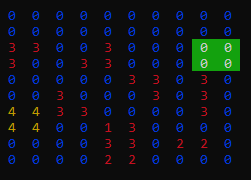

In [27]:
Image("img/piano_mover_grid.png")

- Piano Mover Puzzle è uno dei giochi presentati negli homework del corso di Intelligenza Artificiale della laurea in Informatica dell'Università dell'Aquila.



- Il gioco è composto da una griglia `10x10` su cui ci sono diverse entità composte da tessere:
    1. **Piano**: il piano viene rappresentato dalla porzione di griglia contenente il numero 4 di colore giallo. E' possibile muovere il piano nello spazio.
    
    2. **Ostacoli**: gli ostacoli possono essere di varia tipologia ed avere diverse forme:
        - **1 blocco da 1 tessera**: ostacolo composto da 1 sola tessera.
        - **2 blocchi da 2 tessere**: ostacoli composti da 2 tessere.
        - **6 blocchi da 3 tessere**: ostacoli composti da 3 tessere.
        
        Essi sono tutti di colore rosso e possono essere mossi nello spazio.
    
    3. **Exit**: l'exit viene rappresentato dalla porzione di griglia contenente il numero 0 di colore bianco con colore di background verde. Non è possibile muovere l'exit, ma gli ostacoli ed il piano possono muoversi sull'exit.
    
    4. **Vuoto**: spazio su cui il piano e gli ostacoli possono muoversi liberamente. Esso viene rappresentato dal numero 0 di colore blu.
    


- Il piano e gli ostacoli possono essere mossi orizzontalmente oppure verticalmente sullo spazio Vuoto (**4**) senza che essi si sovrappongano tra loro. Le mosse possibili sono quindi 4:
    - `move_up()`: l'entità viene spostata nello spazio vuoto verso l'alto
    - `move_down()`: l'entità viene spostata nello spazio vuoto verso il basso
    - `move_left()`: l'entità viene spostata nello spazio vuoto verso sinistra
    - `move_right()`: l'entità viene spostata nello spazio vuoto verso destra


- Lo scopo del gioco è quello di muovere il piano fino a quando esso non si trovi completamente sull'exit (**tutte** le tessere del piano devono trovarsi sull'exit). Una volta che questo accade, il gioco termina.

## Implementazione

- Per l'implementazione della griglia, si è deciso di utilizzare come supporto la **libreria esterna** [numpy](https://numpy.org/doc/stable/). La libreria è stata utilizzata per facilitare la gestione dell'array bidimensionale che rappresenta la griglia di Piano Mover. L'installazione di essa avviene mediante il comando: `pip install numpy==1.20.3`

- Per rendere multicolore la stampa della griglia, si è deciso di utilizzare come supporto la **libreria esterna** [colorama](https://pypi.org/project/colorama/). Da essa sono state utilizzate alcune variabili che contengono sequenze di caratteri escape per produrre stampe multicolore su terminale. L'installazione di essa avviene mediante il comando: `pip install colorama==0.4.4`

### Funzioni ausiliarie

- `get_state_from_set(set_of_states, state)`: funzione ausiliaria utilizzata per estrarre lo stato `state` dall'insieme di stati `set_of_states`



- `piano_mover_nearest_neighbors(state, set_of_states)`: funzione ausiliaria che visita gli stati contenuti nel parametro `set_of_states`, e ritorna gli stati che:
    1. derivano da mosse del piano
    2. derivano da mosse degli ostacoli che sono **vicini** al piano
  
  Per decidere la vicinanza di un ostacolo, viene utilizzata la funzione `is_far()`



- `is_far(piano_head, moved_block_head)`: funzione ausiliaria che, dati i parametri `piano_head` (la posizione della testa del piano) e `moved_block_head` (la posizione della testa dell'ultimo blocco mosso), ritorna un boolean che indica se l'ultimo blocco mosso è distante o meno dal piano. Come **Design Decision** si è deciso di considerare lontani tutti i blocchi che sono a distanza > 4 dal piano.



- `obstacle_density(state)`: funzione ausiliaria che calcola la densità di ostacoli presenti sul campo tra il piano e l'exit.

In [28]:
# funzione che estrae lo stato `state` dal
# set di stati `set_of_states`
def get_state_from_set(set_of_states, state):
    for node in set_of_states:
        if node == state:
            return node
    return None


# funzione che si occupa di eseguire un taglio della frontiera:
# dato lo stato `state` e il set di stati `set of states`,
# la funzione inserisce nella soluzione gli stati che derivano
# da mosse eseguite sul piano e sugli ostacoli più vicini
# ad esso. Il ragionamento di base è che le mosse utili sono
# quelle mosse che eseguono uno spostamento del piano e di
# ostacoli che sono vicini ad esso.
#
# return: insieme di stati considerati come i più vicini
def piano_mover_nearest_neighbors(state, set_of_states):
    piano_head_x = state.representation.blocks["piano"].head_x
    piano_head_y = state.representation.blocks["piano"].head_y
    nearest_states = set([])

    for s in set_of_states:
        moved_block = s.representation.moved_block
        if moved_block != "piano":
            moved_block_head_x = s.representation.blocks[moved_block].head_x
            moved_block_head_y = s.representation.blocks[moved_block].head_y
            if is_far(
                (piano_head_x, piano_head_y), (moved_block_head_x, moved_block_head_y)
            ):
                continue

        nearest_states.add(s)
    return nearest_states


# funzione che, dati la tessera di testa del piano (`piano_head`)
# e la tessera di testa di un blocco (`moved_block_head`),
# restituisce un booleano che indica se il blocco è lontano
# dal piano.
# Il ragionamento di base è che un blocco è lontano dal piano
# se si trova a distanza > 4 (Design Decision)
def is_far(piano_head, moved_block_head):
    return (
        math.fabs(piano_head[0] - moved_block_head[0])
        + math.fabs(piano_head[1] - moved_block_head[1])
    ) > 4

In [29]:
# funzione che calcola la densità di ostacoli presenti tra il piano e l'exit
#
# 1. creazione di una sottomatrice che rappresenta lo spazio tra
#    il piano e l'exit
#
# 2. conteggio delle tessere che ostacolano il piano utilizzando la
#    sottomatrice precedentemente calcolata
#
# 3. conteggio della grandezza totale della sottomatrice precedentemente
#    calcolata
#
# 4. conteggio della densità di ostacoli presenti
# (numero tessere ostacoli / grandezza totale sottomatrice)
#
# return: float: [0, 1], indica la densità di ostacoli
# presenti tra il piano e l'exit
def obstacle_density(state):
    piano_coords = (
        state.representation.blocks["piano"].head_x,
        state.representation.blocks["piano"].head_y,
    )
    exit_coords = (
        state.representation.blocks["exit"].head_x,
        state.representation.blocks["exit"].head_y,
    )
    if piano_coords[0] <= exit_coords[0]:
        x_coords = piano_coords[0], exit_coords[0]
    else:
        x_coords = exit_coords[0], piano_coords[0]

    if piano_coords[1] <= exit_coords[1]:
        y_coords = piano_coords[1], exit_coords[1]
    else:
        y_coords = exit_coords[1], piano_coords[1]

    space_between_piano_and_exit = state.representation.grid[
        x_coords[0] : x_coords[1], y_coords[0] : y_coords[1]
    ]

    obstacles_between_piano_and_exit = (
        (space_between_piano_and_exit == 3).sum()
        + (space_between_piano_and_exit == 2).sum()
        + (space_between_piano_and_exit == 1).sum()
    )

    total_space = space_between_piano_and_exit.size

    if total_space == 0:
        return 0
    else:
        obstacle_density = obstacles_between_piano_and_exit / total_space
        return obstacle_density

### Rappresentazione

#### Blocchi da 1 tessera

In [30]:
# 1 block obstacles
class Block_1:
    def __init__(self, id=None, representation=None, pos=None):
        self.id = id
        self.repr = representation

        if pos is None:
            self.pos = []
            self.__generate_positions()
        else:
            self.pos = pos
            self.head_x = pos[0][0]
            self.head_y = pos[0][1]

        self.value = 1

    # metodo che sposta il blocco corrente
    # verso l'alto
    def move_up(self):
        new_head_x = self.head_x - 1
        new_head_y = self.head_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso il basso
    def move_down(self):
        new_head_x = self.head_x + 1
        new_head_y = self.head_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso sinistra
    def move_left(self):
        new_head_x = self.head_x
        new_head_y = self.head_y - 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso destra
    def move_right(self):
        new_head_x = self.head_x
        new_head_y = self.head_y + 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))

        return self.__move(new_pos)

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa chiamante (mediante
    # l'applicazione delle nuove coordinate `new_pos`).
    # Se non è possibile eseguire la mossa,
    # viene restituito None
    def __move(self, new_pos):
        if not self.__collision(new_pos):
            new_blocks = deepcopy(self.repr.blocks)
            new_repr = PianoMoverRepr(dim=self.repr.dim, blocks=new_blocks)
            new_repr.update_block(Block_1(self.id, new_repr, new_pos))
            new_repr.moved_block = self.id

            return new_repr
        return None

    # metodo che si occupa della generazione randomica
    # della posizione del blocco corrente
    def __generate_positions(self):
        while True:
            # H
            self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 1)
            self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 1)

            if self.repr.grid[self.head_x, self.head_y] == 0:
                break

        self.pos = []
        self.pos.append((self.head_x, self.head_y))

    # metodo che restituisce un booleano che indica se
    # il posizionamento `new_pos` è un posizionamento
    # illegale (ovvero un posizionamento che colliderebbe
    # con un blocco preesistente oppure che andrebbe al
    # di fuori della griglia di gioco)
    # restituisce: True se `new_pos` è un posizionamento
    # illegale, False altrimenti.
    def __collision(self, new_pos):
        for pos in new_pos:
            if (
                pos[0] < 0
                or pos[0] > self.repr.get_grid_shape()[0] - 1
                or pos[1] < 0
                or pos[1] > self.repr.get_grid_shape()[1] - 1
                or self.__block_collision(new_pos)
            ):
                return True

        return False

    # metodo che restituisce un booleano che indica se
    # il posizionamento del blocco sulla
    # posizione `new_pos` colliderebbe con un blocco
    # preesistente
    # restituisce: True se il blocco colliderebbe,
    # False altrimenti.
    def __block_collision(self, new_pos):
        for k in self.repr.blocks:
            if self.repr.blocks[k].id != "exit" and self.repr.blocks[k].id != self.id:
                for pos in self.repr.blocks[k].pos:
                    if pos in new_pos:
                        return True

        return False

#### Blocchi da 2 tessere

In [31]:
# 2 blocks obstacles
class Block_2:
    def __init__(self, id=None, representation=None, pos=None):
        self.id = id
        self.repr = representation

        if pos is None:
            self.pos = []
            self.__generate_positions()
        else:
            self.pos = pos
            self.head_x = pos[0][0]
            self.head_y = pos[0][1]
            self.body_x = pos[1][0]
            self.body_y = pos[1][1]

        self.value = 2

    # metodo che sposta il blocco corrente
    # verso l'alto
    def move_up(self):
        new_head_x = self.head_x - 1
        new_head_y = self.head_y
        new_body_x = self.body_x - 1
        new_body_y = self.body_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_x, new_body_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso il basso
    def move_down(self):
        new_head_x = self.head_x + 1
        new_head_y = self.head_y
        new_body_x = self.body_x + 1
        new_body_y = self.body_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_x, new_body_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso sinistra
    def move_left(self):
        new_head_x = self.head_x
        new_head_y = self.head_y - 1
        new_body_x = self.body_x
        new_body_y = self.body_y - 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_x, new_body_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso destra
    def move_right(self):
        new_head_x = self.head_x
        new_head_y = self.head_y + 1
        new_body_x = self.body_x
        new_body_y = self.body_y + 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_x, new_body_y))

        return self.__move(new_pos)

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa chiamante (mediante
    # l'applicazione delle nuove coordinate `new_pos`).
    # Se non è possibile eseguire la mossa,
    # viene restituito None
    def __move(self, new_pos):
        if not self.__collision(new_pos):
            new_blocks = deepcopy(self.repr.blocks)
            new_repr = PianoMoverRepr(dim=self.repr.dim, blocks=new_blocks)
            new_repr.update_block(Block_2(self.id, new_repr, new_pos))
            new_repr.moved_block = self.id

            return new_repr
        return None

    # metodo che si occupa della generazione randomica
    # della posizione del blocco corrente
    def __generate_positions(self):
        while True:
            block_type = random.choice(["hz", "vt"])
            # H*
            if block_type == "hz":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 1)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 2)

                self.body_x = self.head_x
                self.body_y = self.head_y + 1

            # H
            # *
            elif block_type == "vt":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 2)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 1)

                self.body_x = self.head_x + 1
                self.body_y = self.head_y

            if (self.repr.grid[self.head_x, self.head_y] == 0) and (
                self.repr.grid[self.body_x, self.body_y] == 0
            ):
                break

        self.pos = []
        self.pos.append((self.head_x, self.head_y))
        self.pos.append((self.body_x, self.body_y))

    # metodo che restituisce un booleano che indica se
    # il posizionamento `new_pos` è un posizionamento
    # illegale (ovvero un posizionamento che colliderebbe
    # con un blocco preesistente oppure che andrebbe al
    # di fuori della griglia di gioco)
    # restituisce: True se `new_pos` è un posizionamento
    # illegale, False altrimenti.
    def __collision(self, new_pos):
        for pos in new_pos:
            if (
                pos[0] < 0
                or pos[0] > self.repr.get_grid_shape()[0] - 1
                or pos[1] < 0
                or pos[1] > self.repr.get_grid_shape()[1] - 1
                or self.__block_collision(new_pos)
            ):
                return True

        return False

    # metodo che restituisce un booleano che indica se
    # il posizionamento del blocco sulla
    # posizione `new_pos` colliderebbe con un blocco
    # preesistente
    # restituisce: True se il blocco colliderebbe,
    # False altrimenti.
    def __block_collision(self, new_pos):
        for k in self.repr.blocks:
            if self.repr.blocks[k].id != "exit" and self.repr.blocks[k].id != self.id:
                for pos in self.repr.blocks[k].pos:
                    if pos in new_pos:
                        return True

        return False

#### Blocchi da 3 tessere

In [32]:
# 3 blocks obstacles
class Block_3:
    def __init__(self, id=None, representation=None, pos=None):
        self.id = id
        self.repr = representation

        if pos is None:
            self.pos = []
            self.__generate_positions()
        else:
            self.pos = pos
            self.head_x = pos[0][0]
            self.head_y = pos[0][1]
            self.body_1_x = pos[1][0]
            self.body_1_y = pos[1][1]
            self.body_2_x = pos[2][0]
            self.body_2_y = pos[2][1]

        self.value = 3

    # metodo che sposta il blocco corrente
    # verso l'alto
    def move_up(self):
        new_head_x = self.head_x - 1
        new_head_y = self.head_y
        new_body_1_x = self.body_1_x - 1
        new_body_1_y = self.body_1_y
        new_body_2_x = self.body_2_x - 1
        new_body_2_y = self.body_2_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso il basso
    def move_down(self):
        new_head_x = self.head_x + 1
        new_head_y = self.head_y
        new_body_1_x = self.body_1_x + 1
        new_body_1_y = self.body_1_y
        new_body_2_x = self.body_2_x + 1
        new_body_2_y = self.body_2_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso sinistra
    def move_left(self):
        new_head_x = self.head_x
        new_head_y = self.head_y - 1
        new_body_1_x = self.body_1_x
        new_body_1_y = self.body_1_y - 1
        new_body_2_x = self.body_2_x
        new_body_2_y = self.body_2_y - 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso destra
    def move_right(self):
        new_head_x = self.head_x
        new_head_y = self.head_y + 1
        new_body_1_x = self.body_1_x
        new_body_1_y = self.body_1_y + 1
        new_body_2_x = self.body_2_x
        new_body_2_y = self.body_2_y + 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))

        return self.__move(new_pos)

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa chiamante (mediante
    # l'applicazione delle nuove coordinate `new_pos`).
    # Se non è possibile eseguire la mossa,
    # viene restituito None
    def __move(self, new_pos):
        if not self.__collision(new_pos):
            new_blocks = deepcopy(self.repr.blocks)
            new_repr = PianoMoverRepr(dim=self.repr.dim, blocks=new_blocks)
            new_repr.update_block(Block_3(self.id, new_repr, new_pos))
            new_repr.moved_block = self.id

            return new_repr
        return None

    # metodo che si occupa della generazione randomica
    # della posizione del blocco corrente
    def __generate_positions(self):
        while True:
            block_type = random.choice(["hz", "vt", "l_1", "l_2", "l_3", "l_4"])

            # H**
            if block_type == "hz":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 1)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 3)

                self.body_1_x = self.head_x
                self.body_1_y = self.head_y + 1
                self.body_2_x = self.head_x
                self.body_2_y = self.head_y + 2

            # H
            # *
            # *
            elif block_type == "vt":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 3)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 1)

                self.body_1_x = self.head_x + 1
                self.body_1_y = self.head_y
                self.body_2_x = self.head_x + 2
                self.body_2_y = self.head_y

            # H*
            # *
            elif block_type == "l_1":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 2)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 2)

                self.body_1_x = self.head_x
                self.body_1_y = self.head_y + 1
                self.body_2_x = self.head_x + 1
                self.body_2_y = self.head_y

            # H*
            #  *
            elif block_type == "l_2":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 2)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 2)

                self.body_1_x = self.head_x
                self.body_1_y = self.head_y + 1
                self.body_2_x = self.head_x + 1
                self.body_2_y = self.head_y + 1

            # H
            # **
            elif block_type == "l_3":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 2)
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 2)

                self.body_1_x = self.head_x + 1
                self.body_1_y = self.head_y
                self.body_2_x = self.head_x + 1
                self.body_2_y = self.head_y + 1

            #  H
            # **
            elif block_type == "l_4":
                self.head_x = random.randint(0, self.repr.get_grid_shape()[0] - 2)
                self.head_y = random.randint(1, self.repr.get_grid_shape()[1] - 1)

                self.body_1_x = self.head_x + 1
                self.body_1_y = self.head_y
                self.body_2_x = self.head_x + 1
                self.body_2_y = self.head_y - 1

            if (
                (self.repr.grid[self.head_x, self.head_y] == 0)
                and (self.repr.grid[self.body_1_x, self.body_1_y] == 0)
                and (self.repr.grid[self.body_2_x, self.body_2_y] == 0)
            ):
                break

        self.pos = []
        self.pos.append((self.head_x, self.head_y))
        self.pos.append((self.body_1_x, self.body_1_y))
        self.pos.append((self.body_2_x, self.body_2_y))

    # metodo che restituisce un booleano che indica se
    # il posizionamento `new_pos` è un posizionamento
    # illegale (ovvero un posizionamento che colliderebbe
    # con un blocco preesistente oppure che andrebbe al
    # di fuori della griglia di gioco)
    # restituisce: True se `new_pos` è un posizionamento
    # illegale, False altrimenti.
    def __collision(self, new_pos):
        for pos in new_pos:
            if (
                pos[0] < 0
                or pos[0] > self.repr.get_grid_shape()[0] - 1
                or pos[1] < 0
                or pos[1] > self.repr.get_grid_shape()[1] - 1
                or self.__block_collision(new_pos)
            ):
                return True

        return False

    # metodo che restituisce un booleano che indica se
    # il posizionamento del blocco sulla
    # posizione `new_pos` colliderebbe con un blocco
    # preesistente
    # restituisce: True se il blocco colliderebbe,
    # False altrimenti.
    def __block_collision(self, new_pos):
        for k in self.repr.blocks:
            if self.repr.blocks[k].id != "exit" and self.repr.blocks[k].id != self.id:
                for pos in self.repr.blocks[k].pos:
                    if pos in new_pos:
                        return True

        return False

#### Piano

In [33]:
# Piano
class Piano:
    def __init__(self, id=None, representation=None, pos=None):
        self.id = id
        self.repr = representation

        if pos is None:
            self.pos = []
            self.__generate_positions()
        else:
            self.pos = pos
            self.head_x = pos[0][0]
            self.head_y = pos[0][1]
            self.body_1_x = pos[1][0]
            self.body_1_y = pos[1][1]
            self.body_2_x = pos[2][0]
            self.body_2_y = pos[2][1]
            self.body_3_x = pos[3][0]
            self.body_3_y = pos[3][1]

        self.value = 4

    # metodo che sposta il blocco corrente
    # verso l'alto
    def move_up(self):
        new_head_x = self.head_x - 1
        new_head_y = self.head_y
        new_body_1_x = self.body_1_x - 1
        new_body_1_y = self.body_1_y
        new_body_2_x = self.body_2_x - 1
        new_body_2_y = self.body_2_y
        new_body_3_x = self.body_3_x - 1
        new_body_3_y = self.body_3_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))
        new_pos.append((new_body_3_x, new_body_3_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso il basso
    def move_down(self):
        new_head_x = self.head_x + 1
        new_head_y = self.head_y
        new_body_1_x = self.body_1_x + 1
        new_body_1_y = self.body_1_y
        new_body_2_x = self.body_2_x + 1
        new_body_2_y = self.body_2_y
        new_body_3_x = self.body_3_x + 1
        new_body_3_y = self.body_3_y
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))
        new_pos.append((new_body_3_x, new_body_3_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso sinistra
    def move_left(self):
        new_head_x = self.head_x
        new_head_y = self.head_y - 1
        new_body_1_x = self.body_1_x
        new_body_1_y = self.body_1_y - 1
        new_body_2_x = self.body_2_x
        new_body_2_y = self.body_2_y - 1
        new_body_3_x = self.body_3_x
        new_body_3_y = self.body_3_y - 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))
        new_pos.append((new_body_3_x, new_body_3_y))

        return self.__move(new_pos)

    # metodo che sposta il blocco corrente
    # verso destra
    def move_right(self):
        new_head_x = self.head_x
        new_head_y = self.head_y + 1
        new_body_1_x = self.body_1_x
        new_body_1_y = self.body_1_y + 1
        new_body_2_x = self.body_2_x
        new_body_2_y = self.body_2_y + 1
        new_body_3_x = self.body_3_x
        new_body_3_y = self.body_3_y + 1
        new_pos = []
        new_pos.append((new_head_x, new_head_y))
        new_pos.append((new_body_1_x, new_body_1_y))
        new_pos.append((new_body_2_x, new_body_2_y))
        new_pos.append((new_body_3_x, new_body_3_y))

        return self.__move(new_pos)

    # metodo che restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa chiamante (mediante
    # l'applicazione delle nuove coordinate `new_pos`).
    # Se non è possibile eseguire la mossa,
    # viene restituito None
    def __move(self, new_pos):
        if not self.__collision(new_pos):
            new_blocks = deepcopy(self.repr.blocks)
            new_repr = PianoMoverRepr(dim=self.repr.dim, blocks=new_blocks)
            new_repr.update_block(Piano(self.id, new_repr, new_pos))
            new_repr.moved_block = self.id

            return new_repr
        return None

    # metodo che si occupa della generazione randomica
    # della posizione del blocco corrente
    def __generate_positions(self):
        while True:
            # H*
            # **
            # orientazione 1 -> piano sul basso della griglia
            # orientazione 2 -> piano sulla sinistra della griglia
            orientation = random.choice([0, 1])
            if orientation == 0:
                self.head_x = self.repr.get_grid_shape()[0] - 2
                self.head_y = random.randint(0, self.repr.get_grid_shape()[1] - 2)
            elif orientation == 1:
                self.head_x = random.randint(0, self.repr.get_grid_shape()[1] - 2)
                self.head_y = 0

            self.body_1_x = self.head_x
            self.body_1_y = self.head_y + 1
            self.body_2_x = self.head_x + 1
            self.body_2_y = self.head_y
            self.body_3_x = self.head_x + 1
            self.body_3_y = self.head_y + 1

            if (
                (self.repr.grid[self.head_x, self.head_y] == 0)
                and (self.repr.grid[self.body_1_x, self.body_1_y] == 0)
                and (self.repr.grid[self.body_2_x, self.body_2_y] == 0)
                and (self.repr.grid[self.body_3_x, self.body_3_y] == 0)
            ):
                break

        self.pos = []
        self.pos.append((self.head_x, self.head_y))
        self.pos.append((self.body_1_x, self.body_1_y))
        self.pos.append((self.body_2_x, self.body_2_y))
        self.pos.append((self.body_3_x, self.body_3_y))

    # metodo che restituisce un booleano che indica se
    # il posizionamento `new_pos` è un posizionamento
    # illegale (ovvero un posizionamento che colliderebbe
    # con un blocco preesistente oppure che andrebbe al
    # di fuori della griglia di gioco)
    # restituisce: True se `new_pos` è un posizionamento
    # illegale, False altrimenti.
    def __collision(self, new_pos):
        for pos in new_pos:
            if (
                pos[0] < 0
                or pos[0] > self.repr.get_grid_shape()[0] - 1
                or pos[1] < 0
                or pos[1] > self.repr.get_grid_shape()[1] - 1
                or self.__block_collision(new_pos)
            ):
                return True

        return False

    # metodo che restituisce un booleano che indica se
    # il posizionamento del blocco sulla
    # posizione `new_pos` colliderebbe con un blocco
    # preesistente
    # restituisce: True se il blocco colliderebbe,
    # False altrimenti.
    def __block_collision(self, new_pos):
        for k in self.repr.blocks:
            if self.repr.blocks[k].id != "exit" and self.repr.blocks[k].id != self.id:
                for pos in self.repr.blocks[k].pos:
                    if pos in new_pos:
                        return True

        return False

#### Exit

In [34]:
# Exit
class Exit:
    def __init__(self, id=None, representation=None, piano_block=None, pos=None):
        self.id = id
        self.repr = representation
        self.piano_block = piano_block

        if pos is None:
            self.pos = []
            self.head_x = None
            self.head_y = None
            self.body_1_x = None
            self.body_1_y = None
            self.body_2_x = None
            self.body_2_y = None
            self.body_3_x = None
            self.body_3_y = None
            self.__generate_positions()
        else:
            self.pos = pos
            self.head_x = pos[0][0]
            self.head_y = pos[0][1]
            self.body_1_x = pos[1][0]
            self.body_1_y = pos[1][1]
            self.body_2_x = pos[2][0]
            self.body_2_y = pos[2][1]
            self.body_3_x = pos[3][0]
            self.body_3_y = pos[3][1]

    # metodo che si occupa della generazione randomica
    # della posizione del blocco corrente
    def __generate_positions(self):
        # H*
        # **
        self.head_x = self.repr.get_grid_shape()[0] - self.piano_block.head_x - 2
        self.head_y = self.repr.get_grid_shape()[1] - self.piano_block.head_y - 2

        self.body_1_x = self.head_x
        self.body_1_y = self.head_y + 1
        self.body_2_x = self.head_x + 1
        self.body_2_y = self.head_y
        self.body_3_x = self.head_x + 1
        self.body_3_y = self.head_y + 1

        self.pos = []
        self.pos.append((self.head_x, self.head_y))
        self.pos.append((self.body_1_x, self.body_1_y))
        self.pos.append((self.body_2_x, self.body_2_y))
        self.pos.append((self.body_3_x, self.body_3_y))

#### Piano Mover

In [35]:
# Piano Mover representation
class PianoMoverRepr(Representation):
    def __init__(self, dim=(10, 10), blocks=None):
        self.dim = dim
        self.grid = np.zeros(shape=dim, dtype=int)

        if blocks is None:
            self.blocks = {}
            self.__generate_blocks()
        else:
            self.blocks = blocks
            self.update_grid()

        # questa variabile contiene l'ultimo
        # blocco mosso
        self.moved_block = None

    def __eq__(self, other):
        if not isinstance(other, PianoMoverRepr):
            return False
        return np.array_equal(self.grid, other.grid)

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(str(self.grid))

    # metodo che si occupa della generazione
    # randomica dei blocchi sulla griglia
    def __generate_blocks(self):
        self.blocks["piano"] = Piano("piano", self)
        self.update_grid()
        self.blocks["exit"] = Exit("exit", self, self.blocks["piano"])
        self.update_grid()
        self.blocks["3_1"] = Block_3("3_1", self)
        self.update_grid()
        self.blocks["3_2"] = Block_3("3_2", self)
        self.update_grid()
        self.blocks["3_3"] = Block_3("3_3", self)
        self.update_grid()
        self.blocks["3_4"] = Block_3("3_4", self)
        self.update_grid()
        self.blocks["3_5"] = Block_3("3_5", self)
        self.update_grid()
        self.blocks["3_6"] = Block_3("3_6", self)
        self.update_grid()
        self.blocks["2_1"] = Block_2("2_1", self)
        self.update_grid()
        self.blocks["2_2"] = Block_2("2_2", self)
        self.update_grid()
        self.blocks["1_1"] = Block_1("1_1", self)
        self.update_grid()

    # metodo che importa la struttura di blocchi
    # rappresentata dal parametro `block_map`
    def import_blocks_structure(self, block_map):
        self.blocks = {}
        self.update_grid()
        self.blocks["piano"] = Piano("piano", self, pos=block_map["piano"])
        self.update_grid()
        self.blocks["exit"] = Exit(
            "exit", self, self.blocks["piano"], pos=block_map["exit"]
        )
        self.update_grid()
        self.blocks["3_1"] = Block_3("3_1", self, pos=block_map["3_1"])
        self.update_grid()
        self.blocks["3_2"] = Block_3("3_2", self, pos=block_map["3_2"])
        self.update_grid()
        self.blocks["3_3"] = Block_3("3_3", self, pos=block_map["3_3"])
        self.update_grid()
        self.blocks["3_4"] = Block_3("3_4", self, pos=block_map["3_4"])
        self.update_grid()
        self.blocks["3_5"] = Block_3("3_5", self, pos=block_map["3_5"])
        self.update_grid()
        self.blocks["3_6"] = Block_3("3_6", self, pos=block_map["3_6"])
        self.update_grid()
        self.blocks["2_1"] = Block_2("2_1", self, pos=block_map["2_1"])
        self.update_grid()
        self.blocks["2_2"] = Block_2("2_2", self, pos=block_map["2_2"])
        self.update_grid()
        self.blocks["1_1"] = Block_1("1_1", self, pos=block_map["1_1"])
        self.update_grid()

    # metodo che esporta la struttura dei blocchi
    # della rappresentazione corrente.
    # Restituisce: dict -> un dizionario con la
    # seguente struttura:
    # {'block': block_positions}
    def export_blocks_structure(self):
        structure = {}
        for block in self.blocks:
            structure[block] = self.blocks[block].pos
        return structure

    # metodo che esegue l'aggiornamento di un blocco
    # presente nella rappresentazione
    def update_block(self, block):
        self.blocks[block.id] = block
        self.update_grid()

    # metodo che aggiorna la griglia che contiene
    # le tessere che rappresentano i blocchi
    def update_grid(self):
        self.grid = np.zeros(shape=self.dim, dtype=int)
        for k in self.blocks:
            if k != "exit":
                block = self.blocks[k]
                for block_coordinates in block.pos:
                    self.grid[block_coordinates[0], block_coordinates[1]] = block.value

    # metodo che restituisce una tupla che rappresenta
    # la forma (shape) della griglia corrente.
    # Restituisce: shape (x, y) della griglia corrente
    def get_grid_shape(self):
        return np.shape(self.grid)

    # metodo che stampa a video la rappresentazione corrente
    def print(self):
        exit_block = self.blocks.get("exit")

        for i in range(self.get_grid_shape()[0]):
            for j in range(self.get_grid_shape()[1]):
                exit_block_cell = (exit_block is not None) and (
                    (i == exit_block.head_x and j == exit_block.head_y)
                    or (i == exit_block.body_1_x and j == exit_block.body_1_y)
                    or (i == exit_block.body_2_x and j == exit_block.body_2_y)
                    or (i == exit_block.body_3_x and j == exit_block.body_3_y)
                )

                if self.grid[i, j] == 0 and not exit_block_cell:
                    # tessera vuota
                    print(
                        "{} {}{} {}".format(
                            Back.BLACK, Fore.BLUE, self.grid[i, j], Style.RESET_ALL
                        ),
                        end="",
                    )
                elif (
                    self.grid[i, j] == 1 or self.grid[i, j] == 2 or self.grid[i, j] == 3
                ):
                    # tessera di un ostacolo
                    print(
                        "{} {}{} {}".format(
                            Back.BLACK, Fore.RED, self.grid[i, j], Style.RESET_ALL
                        ),
                        end="",
                    )
                elif self.grid[i, j] == 4:
                    # tessera del piano
                    print(
                        "{} {}{} {}".format(
                            Back.BLACK, Fore.YELLOW, self.grid[i, j], Style.RESET_ALL
                        ),
                        end="",
                    )
                elif exit_block_cell:
                    # tessera dell'exit
                    print(
                        "{} {}{} {}".format(
                            Back.GREEN, Fore.WHITE, self.grid[i, j], Style.RESET_ALL
                        ),
                        end="",
                    )
            print()

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di fine gioco
    def is_endgame(self):
        exit_block = self.blocks["exit"]
        piano_block = self.blocks["piano"]

        if len(exit_block.pos) != len(piano_block.pos):
            return False

        return (
            (piano_block.pos[0] == exit_block.pos[0])
            and (piano_block.pos[1] == exit_block.pos[1])
            and (piano_block.pos[2] == exit_block.pos[2])
            and (piano_block.pos[3] == exit_block.pos[3])
        )

### Stato

In [36]:
# Piano Mover state
class PianoMoverState(State):
    def __init__(
        self,
        parent=None,
        repr=None,
    ):
        # lo stato padre dello stato corrente,
        # None se lo stato corrente è lo stato iniziale
        self.parent = parent

        # nel caso in cui non viene passata alcuna rappresentazione,
        # viene generata la rappresentazione iniziale del gioco
        if repr is None:
            self.representation = PianoMoverRepr()
        else:
            self.representation = repr

        # i parametri g, h, f sono i diversi punteggi
        # attribuibili allo stato corrente
        self.g = None
        self.h = None
        self.f = None

    def __eq__(self, other):
        if not isinstance(other, PianoMoverState):
            return False
        return self.representation == other.representation

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return self.representation.__hash__()

    # metodo che stampa a video lo stato corrente
    def print(self):
        self.representation.print()
        print()
        print(" g(n): {}".format(self.g))
        print(" h(n): {}".format(self.h))
        print(" f(n): {}".format(self.f))
        print("------------------------------")
        print()

    # metodo che ritorna un booleano che indica se
    # lo stato corrente corrisponde
    # ad uno stato di fine gioco
    def is_endgame(self):
        return self.representation.is_endgame()

### Gioco

In [37]:
# Piano Mover game
class PianoMoverGame(Game):
    # metodo che ritorna un set di stati che corrispondono alle mosse
    # legali che è possibile eseguire a partire dallo stato `state`
    # passato come parametro
    def neighbors(self, state):
        children = set([])

        # esegui ogni possibile mossa
        moves = []
        for block in state.representation.blocks:
            if block != "exit":
                moves.append(state.representation.blocks[block].move_up())
                moves.append(state.representation.blocks[block].move_down())
                moves.append(state.representation.blocks[block].move_left())
                moves.append(state.representation.blocks[block].move_right())

        for move in moves:
            if move is not None:
                # creiamo soltanto stati ammissibili
                child = PianoMoverState(parent=state, repr=move)
                children.add(child)

        return children

### Euristiche

- Vengono di seguito presentate 2 euristiche per il gioco Piano Mover:
    - **Manhattan distance**: euristica che valuta lo stato corrente attraverso il calcolo della distanza di Manhattan tra il piano e l'exit.

    - **Manhattan distance with obstacle density**: euristica che valuta lo stato corrente attraverso il calcolo della distanza di Manhattan tra il piano e l'exit con l'aggiunta di un valore basato sulla densità di ostacoli presenti tra il piano e l'exit. L'euristica è stata inventata come esperimento per vedere se con l'introduzione di una penalità (basata sulla densità di ostacoli presenti tra il piano e l'exit) sulla distanza di Manhattan, si hanno dei risultati migliori rispetto alla distanza di Manhattan standard. I risultati dei test verranno presentati nella sotto-sezione **Analisi e presentazione dei risultati** dei **Test su Piano Mover** della sezione **Statistiche**. In essa verranno confrontate le euristiche insieme agli algoritmi di ricerca utilizzati.

In [38]:
# Piano Mover heuristics

# h(n): Manhattan distance
# funzione euristica per Piano Mover che utilizza la
# distanza di Manhattan tra il piano e l'exit come funzione
# di valutazione dello stato
class PianoMoverManhattanDistance(Heuristic):
    # stima del costo dallo stato `state` allo stato goal
    def H(self, state):
        piano_pos = state.representation.blocks["piano"].pos
        exit_pos = state.representation.blocks["exit"].pos

        distance = 0.0
        positions = zip(piano_pos, exit_pos)

        # viene considerato tutto il corpo delle entità
        # non solo le teste
        for pos in list(positions):
            piano_coord = pos[0]
            exit_coord = pos[1]
            distance += math.fabs(piano_coord[0] - exit_coord[0]) + math.fabs(
                piano_coord[1] - exit_coord[1]
            )

        return distance


# h(n): Manhattan distance with obstacle density
# funzione euristica per Piano Mover che utilizza una
# combinazione tra la distanza di Manhattan tra
# il piano e l'exit e la densità di ostacoli presenti
# tra il piano e l'exit come funzione
# di valutazione dello stato
class PianoMoverManhattanDistanceWithObstacleDensity(Heuristic):
    def __init__(self):
        self.manhattan_distance = PianoMoverManhattanDistance()

    # stima del costo dallo stato `state` allo stato goal
    def H(self, state):
        return self.manhattan_distance.H(state) + (obstacle_density(state) * 4)

### Algoritmi di ricerca applicabili

- A\*
- Best First

### Definizione funzione distanza (dallo stato iniziale allo stato corrente)

- Definizione della funzione $c(s_0, s)$ che calcola la distanza tra lo stato iniziale (root) e lo stato corrente. Nello stato, il punteggio sarà salvato nella variabile g.

- La funzione `piano_mover_distance_from_root(state)` calcola il costo del path dallo stato root allo stato corrente `state`. La funzione assegna 0 al costo del path se lo stato `state` è lo stato root. Altrimenti, il costo si incrementa a seconda della mossa effettuata nello stato `state`. Se è stato mosso il piano, il costo si incrementa di 4. Se è stato mosso un ostacolo, il costo si incrementa di 6, rendendo quindi più costose le mosse che muovono gli ostacoli (Design Decision).

In [39]:
# funzione che definisce la distanza
# dello stato `state` dallo stato root: g(n)
def piano_mover_distance_from_root(state):
    # se lo stato `state` passato come parametro:
    #   - è lo stato root -> state.g = 0
    if state.parent is None:
        return 0

    # se lo stato `state` passato come parametro è uno stato derivato da:
    #   - mossa del piano      -> state.g = state.parent.g + 4
    #   - mossa di un ostacolo -> state.g = state.parent.g + 6
    if state.representation.moved_block == "piano":
        # se l'ultimo blocco mosso è il piano, il costo della mossa è 4
        # (abbiamo mosso 4 tessere di 1 posizione)
        return state.parent.g + 4
    else:
        # se l'ultimo blocco mosso è un ostacolo, il costo della mossa è 6
        # (costo movimento ostacolo > costo movimento piano)
        return state.parent.g + 6

## Esecuzione

- Utilizzo infrastruttura a singolo agente

In [40]:
# griglie generate precedentemente in modo randomico per eseguire
# statistiche sulle esecuzioni

piano_mover_grid_1 = {
    "piano": [(8, 8), (8, 9), (9, 8), (9, 9)],
    "exit": [(0, 0), (0, 1), (1, 0), (1, 1)],
    "3_1": [(5, 3), (6, 3), (7, 3)],
    "3_2": [(0, 8), (1, 8), (2, 8)],
    "3_3": [(8, 6), (8, 7), (9, 6)],
    "3_4": [(2, 2), (2, 3), (2, 4)],
    "3_5": [(2, 9), (3, 9), (3, 8)],
    "3_6": [(5, 6), (5, 7), (6, 6)],
    "2_1": [(6, 2), (7, 2)],
    "2_2": [(5, 1), (6, 1)],
    "1_1": [(0, 5)],
}

piano_mover_grid_2 = {
    "piano": [(6, 0), (6, 1), (7, 0), (7, 1)],
    "exit": [(2, 8), (2, 9), (3, 8), (3, 9)],
    "3_1": [(4, 5), (4, 6), (5, 6)],
    "3_2": [(5, 2), (6, 2), (6, 3)],
    "3_3": [(7, 5), (8, 5), (8, 4)],
    "3_4": [(4, 8), (5, 8), (6, 8)],
    "3_5": [(2, 0), (2, 1), (3, 0)],
    "3_6": [(2, 4), (3, 4), (3, 3)],
    "2_1": [(8, 7), (8, 8)],
    "2_2": [(9, 4), (9, 5)],
    "1_1": [(7, 4)],
}

piano_mover_grid_3 = {
    "piano": [(3, 0), (3, 1), (4, 0), (4, 1)],
    "exit": [(5, 8), (5, 9), (6, 8), (6, 9)],
    "3_1": [(7, 2), (8, 2), (8, 3)],
    "3_2": [(8, 1), (9, 1), (9, 2)],
    "3_3": [(0, 6), (0, 7), (1, 6)],
    "3_4": [(6, 2), (6, 3), (6, 4)],
    "3_5": [(5, 1), (6, 1), (7, 1)],
    "3_6": [(1, 4), (2, 4), (2, 5)],
    "2_1": [(4, 9), (5, 9)],
    "2_2": [(7, 4), (7, 5)],
    "1_1": [(1, 0)],
}

piano_mover_grid_4 = {
    "piano": [(0, 0), (0, 1), (1, 0), (1, 1)],
    "exit": [(8, 8), (8, 9), (9, 8), (9, 9)],
    "3_1": [(0, 6), (1, 6), (2, 6)],
    "3_2": [(0, 2), (1, 2), (2, 2)],
    "3_3": [(8, 6), (8, 7), (9, 7)],
    "3_4": [(3, 8), (4, 8), (4, 9)],
    "3_5": [(5, 7), (6, 7), (6, 6)],
    "3_6": [(4, 2), (4, 3), (4, 4)],
    "2_1": [(0, 4), (0, 5)],
    "2_2": [(1, 4), (1, 5)],
    "1_1": [(6, 9)],
}

piano_mover_grid_5 = {
    "piano": [(8, 1), (8, 2), (9, 1), (9, 2)],
    "exit": [(0, 7), (0, 8), (1, 7), (1, 8)],
    "3_1": [(1, 7), (1, 8), (2, 7)],
    "3_2": [(7, 6), (7, 7), (8, 7)],
    "3_3": [(6, 6), (6, 7), (6, 8)],
    "3_4": [(3, 1), (3, 2), (4, 1)],
    "3_5": [(0, 0), (0, 1), (1, 0)],
    "3_6": [(3, 6), (3, 7), (4, 7)],
    "2_1": [(8, 3), (8, 4)],
    "2_2": [(7, 8), (8, 8)],
    "1_1": [(3, 5)],
}

piano_mover_grid_6 = {
    "piano": [(0, 0), (0, 1), (1, 0), (1, 1)],
    "exit": [(8, 8), (8, 9), (9, 8), (9, 9)],
    "3_1": [(0, 4), (0, 5), (1, 5)],
    "3_2": [(6, 3), (7, 3), (7, 2)],
    "3_3": [(3, 0), (4, 0), (5, 0)],
    "3_4": [(3, 6), (4, 6), (5, 6)],
    "3_5": [(5, 5), (6, 5), (6, 6)],
    "3_6": [(4, 8), (4, 9), (5, 9)],
    "2_1": [(6, 8), (6, 9)],
    "2_2": [(8, 8), (8, 9)],
    "1_1": [(0, 7)],
}

In [41]:
# inizializzazione gioco ed euristica
# heuristic = PianoMoverManhattanDistanceWithObstacleDensity()
heuristic = PianoMoverManhattanDistance()
game = PianoMoverGame()

# inizializzazione algoritmo di ricerca
search_algorithm = A_star(
    heuristic=heuristic,
    game=game,
    g_score_function=piano_mover_distance_from_root,
    print_status=True,
)

# search_algorithm = BestFirst(
#     heuristic=heuristic,
#     game=game,
#     print_status=True,
# )

# settaggio della funzione che esegue il taglio degli stati neighbors
# (in questo modo consideriamo soltanto i neighbors più vicini)
search_algorithm.set_cutset_function(piano_mover_nearest_neighbors)

initial_state = PianoMoverState()
# import di una griglia già esistente
# commentare per generare randomicamente una grigla
initial_state.representation.import_blocks_structure(piano_mover_grid_6)
# rimuovere il commento per esportare la griglia
# print(initial_state.representation.export_blocks_structure())
print("Stato iniziale")
print()
initial_state.print()

Stato iniziale

 4  4  0  0  3  3  0  1  0  0 
 4  4  0  0  0  3  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0 
 3  0  0  0  0  0  3  0  0  0 
 3  0  0  0  0  0  3  0  3  3 
 3  0  0  0  0  3  3  0  0  3 
 0  0  0  3  0  3  3  0  2  2 
 0  0  3  3  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  2  2 
 0  0  0  0  0  0  0  0  0  0 

 g(n): None
 h(n): None
 f(n): None
------------------------------



In [42]:
# inizializzazione agente
agent = Agent(search_algorithm=search_algorithm, initial_state=initial_state)

# inizio simulazione
main_single_agent(initial_state, agent)

 4  4  0  0  3  3  0  1  0  0 
 4  4  0  0  0  3  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0 
 3  0  0  0  0  0  3  0  0  0 
 3  0  0  0  0  0  3  0  3  3 
 3  0  0  0  0  3  3  0  0  3 
 0  0  0  3  0  3  3  0  2  2 
 0  0  3  3  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  2  2 
 0  0  0  0  0  0  0  0  0  0 

 g(n): 0
 h(n): 64.0
 f(n): 64.0
------------------------------


 0  4  4  0  3  3  0  1  0  0 
 0  4  4  0  0  3  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0 
 3  0  0  0  0  0  3  0  0  0 
 3  0  0  0  0  0  3  0  3  3 
 3  0  0  0  0  3  3  0  0  3 
 0  0  0  3  0  3  3  0  2  2 
 0  0  3  3  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  2  2 
 0  0  0  0  0  0  0  0  0  0 

 g(n): 4
 h(n): 60.0
 f(n): 64.0
------------------------------


 0  0  0  0  3  3  0  1  0  0 
 0  4  4  0  0  3  0  0  0  0 
 0  4  4  0  0  0  0  0  0  0 
 3  0  0  0  0  0  3  0  0  0 
 3  0  0  0  0  0  3  0  3  3 
 3  0  0  0  0  3  3  0  0  3 
 0  0  0  3  0  3  3  0  2  2 
 0  0  3  3  0  0  0  0  0  0

In [43]:
print(f"Grandezza finale orizzonte: {len(agent.search_algorithm.horizon)}")
print(f"Grandezza finale esplorati: {len(agent.search_algorithm.explored)}")
print(f"Tempo di azione medio     : {agent.get_average_action_time()}")

Grandezza finale orizzonte: 4342
Grandezza finale esplorati: 873
Tempo di azione medio     : 0.03149869351862222


# Scacchi

## Descrizione del gioco

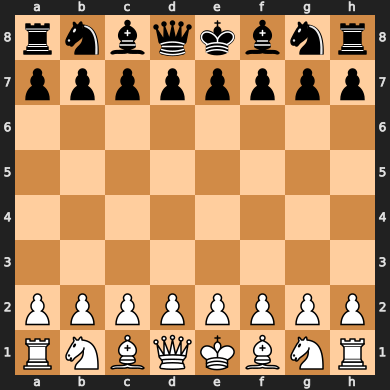

In [44]:
Image("img/chess_board.png")

- Il gioco degli scacchi è un gioco di strategia che si svolge su una tavola quadrata formata da 64 caselle detta scacchiera.



- la scacchiera è composta da 2 colori alternati sulla quale ogni giocatore dispone 16 pezzi (bianchi o neri a seconda del giocatore)



- i 2 giocatori sfidanti sono:
    - il "Bianco"
    - il "Nero"



- i pezzi disponibili sono:
    - 1 Re (King)
    
    - 1 Regina (Queen)
    
    - 2 Alfieri (Bishop)
    
    - 2 Cavalli (Knight)
    
    - 2 Torri (Rook)
    
    - 8 Pedoni (Pawn)
    


- ogni casella può essere occupata da 1 solo pezzo, che può catturare (o mangiare) il pezzo avversario andando ad occuparne la casella.



- l'obiettivo del gioco è fare **scacco matto**, ovvero minacciare la cattura del Re avversario in modo tale che l'altro giocatore non abbia mosse legali disponibili.


- è tra i giochi più popolari del mondo ed è molto complesso: si stima che il numero di combinazioni legalmente ammesse dei 32 pezzi sulle 64 caselle della scacchiera sia compreso tra $10^{43}$ e $10^{50}$ e che la dimensione dell'albero delle mosse sia di circa $10^{123}$, con un numero di possibili partite diverse pari a circa $10^{10^{50}}$

## Implementazione

#### Librerie esterne utilizzate come supporto al gioco degli Scacchi:
- Per quanto riguarda l'implementazione della rappresentazione del gioco degli scacchi, si è deciso di utilizzare come supporto la **libreria esterna** [python-chess](https://python-chess.readthedocs.io/en/latest/). Essa fornisce supporto per la generazione delle mosse legali negli scacchi, per l'implementazione delle regole del gioco, per la conoscenza delle varie terminazioni possibili di una partita a scacchi e per la stampa della scacchiera (in formato SVG). L'installazione di essa avviene mediante il comando: `pip install chess==1.6.1`

- Per una ragione di efficienza nei calcoli, si è deciso di utilizzare come supporto la **libreria esterna** [numpy](https://numpy.org/doc/stable/). Da essa è stata utilizzata la variabile `np.inf`, che contiene una rappresentazione dell'infinito più efficiente da utilizzare rispetto alla versione built-in di Python. L'installazione di essa avviene mediante il comando: `pip install numpy==1.20.3`

#### Librerie esterne utilizzate come supporto alla stampa:
- Per rendere multicolore la stampa della scacchiera in versione console, si è deciso di utilizzare come supporto la **libreria esterna** [colorama](https://pypi.org/project/colorama/). Da essa sono state utilizzate alcune variabili che contengono sequenze di caratteri escape per produrre stampe multicolore su terminale. L'installazione di essa avviene mediante il comando: `pip install colorama==0.4.4`

- Per permettere anche la stampa in formato PNG della scacchiera, si è deciso di utilizzare come supporto la **libreria esterna** [cairosvg](https://cairosvg.org/). Con essa è possibile convertire l'immagine della scacchiera dal formato SVG al formato PNG. L'installazione di essa avviene mediante il comando: `pip install cairosvg==2.5.2`

### Rappresentazione

In [45]:
# Chess representation
class ChessRepr(TurnBasedRepresentation):
    def __init__(self, board=None):
        if board is None:
            self.board = chess.Board()
        else:
            self.board = board

    def __eq__(self, other):
        if not isinstance(other, ChessRepr):
            return False
        return str(self.board) == str(other.board)

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(str(self.board))

    def __str__(self):
        return str(self.board)

    # metodo che ritorna le mosse legali che
    # possono essere compiute dalla
    # scacchiera corrente
    def legal_moves(self):
        return self.board.legal_moves

    # metodo che, data la mossa `move`,
    # restituisce una nuova rappresentazione
    # su cui viene eseguita la mossa.
    # Se la mossa `move` è una mossa non legale,
    # viene restituito None
    def make_move(self, move):
        if move in self.legal_moves():
            updated_board = self.board.copy()
            updated_board.push(move)

            return ChessRepr(board=updated_board)
        return None

    # metodo che ritorna il colore vincente
    # ({White, Black}) se la rappresentazione
    # corrente corrisponde ad una situazione
    # di fine gioco con vittoria per scacco
    # matto.
    # Altrimenti viene restituito None
    def winner_player(self):
        if self.is_victory():
            outcome = self.board.outcome()
            if outcome is not None:
                return "White" if outcome.winner else "Black"
        return None

    # metodo che restituisce un booleano che
    # corrisponde al colore vincente
    # ({White, Black}) se la rappresentazione
    # corrente corrisponde ad una situazione
    # di fine gioco con vittoria per scacco
    # matto. Altrimenti restituisce None.
    # Return:
    #     True : se il colore vincente è White
    #     False: se il colore vincente è Black
    #     None : altrimenti
    def winner(self):
        if self.is_victory():
            outcome = self.board.outcome()
            if outcome is not None:
                return outcome.winner
        return None

    # metodo che restituisce un oggetto che indica
    # il risultato dalla partita a scacchi nel caso in
    # cui la rappresentazione corrente corrisponde ad una
    # situazione di fine gioco. Altrimenti viene
    # restituito None
    def outcome(self):
        if self.is_endgame():
            outcome = self.board.outcome()
            if outcome is not None:
                return outcome.termination
        return None

    # metodo che restituisce un booleano che indica
    # il giocatore che deve muovere:
    #   True : il giocatore `White` deve muovere
    #   False: il giocatore `Black` deve muovere
    def turn(self):
        return self.board.turn

    # metodo che restituisce un booleano che indica
    # se la rappresentazione corrente corrisponde
    # ad una situazione di fine gioco per pareggio
    def is_draw(self):
        return (
            self.board.is_stalemate()
            or self.board.is_insufficient_material()
            or self.board.is_fivefold_repetition()
            or self.board.is_seventyfive_moves()
        )

    # metodo che restituisce un booleano che indica
    # se la rappresentazione corrente corrisponde
    # ad una situazione di gioco in cui il giocatore
    # che deve muovere può chiedere un pareggio
    # con la regola fivefold repetition oppure con
    # la threefold repetition
    #
    # Nota: il controllo può essere lento: utilizzare
    # con attenzione
    def can_claim_draw(self):
        return self.board.can_claim_draw()

    # metodo che restituisce un dizionario (dict)
    # che ha la seguente struttura:
    # {square: piece} con:
    #   square: tipo intero che rappresenta la casella
    #           occupata da piece
    #   piece : tipo chess.Piece che rappresenta il
    #           il pezzo sulla scacchiera
    def piece_map(self):
        return self.board.piece_map()

    # metodo che restituisce l'ultima mossa
    # eseguita sulla scacchiera
    def get_last_move(self):
        if len(self.board.move_stack) > 0:
            return self.board.move_stack[-1]
        else:
            return None

    # metodo che restituisce un booleano che indica
    # se la rappresentazione corrente corrisponde
    # ad una situazione di gioco in cui la scacchiera
    # si trova nella fase di fine gioco.
    # La fase di fine gioco inizia se:
    #    - entrambi i lati della scacchiera
    #      non hanno la Regina (Queen)
    #
    #    - ogni lato che ha una Regina (Queen) non ha altri
    #      pezzi oppure ha massimo 1 Minorpiece (Bishop, Knight)
    def is_in_endgame_phase(self):
        # Regine
        white_queens = len(self.board.pieces(chess.QUEEN, chess.WHITE))
        black_queens = len(self.board.pieces(chess.QUEEN, chess.BLACK))

        # se entrambi i lati non hanno Regine -> endgame phase
        if white_queens == 0 and black_queens == 0:
            return True

        # Minorpieces
        white_bishops = len(self.board.pieces(chess.BISHOP, chess.WHITE))
        black_bishops = len(self.board.pieces(chess.BISHOP, chess.BLACK))
        white_knights = len(self.board.pieces(chess.KNIGHT, chess.WHITE))
        black_knights = len(self.board.pieces(chess.KNIGHT, chess.BLACK))
        white_minors = white_bishops + white_knights
        black_minors = black_bishops + black_knights

        white_rooks = len(self.board.pieces(chess.ROOK, chess.WHITE))
        black_rooks = len(self.board.pieces(chess.ROOK, chess.BLACK))

        # se ogni lato che ha una regina, non ha altri pezzi oppure ha
        # 1 Minorpiece al massimo -> endgame phase
        # fmt: off
        white_endgame_condition_with_queen = (
            white_queens == 1 and (white_rooks == 0 and white_minors <= 1)
        )
        black_endgame_condition_with_queen = (
            black_queens == 1 and (black_rooks == 0 and black_minors <= 1)
        )
        # fmt: on

        if (
            (white_endgame_condition_with_queen and black_queens == 0)
            or (black_endgame_condition_with_queen and white_queens == 0)
            or (
                white_endgame_condition_with_queen
                and black_endgame_condition_with_queen
            )
        ):
            return True

        return False

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di partita terminata
    # (fine gioco)
    def is_endgame(self):
        return self.board.is_game_over()

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di fine gioco con vittoria
    # per scacco matto (checkmate)
    def is_victory(self):
        return self.board.is_checkmate()

    # metodo che stampa a video la rappresentazione corrente
    # stampando un'immagine SVG della scacchiera
    def __print_svg(self):
        display(self.board)

    # metodo che stampa a video la rappresentazione corrente
    # stampando un'immagine PNG della scacchiera
    def __print_png(self, width=300):
        svg_board = chess.svg.board(board=self.board, size=width)
        svg_bytes = cairosvg.svg2png(svg_board)
        if svg_bytes is not None:
            display(Image(svg_bytes, width=width))

    # metodo che stampa a video la rappresentazione corrente
    # senza stampare la cornice della scacchiera
    def __print_console(self):
        print(self.board)

    # metodo che stampa a video la rappresentazione corrente
    # stampando anche la cornice della scacchiera
    def __print_console_cornered(self):
        board = [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
        ]

        for square, piece in self.board.piece_map().items():
            row = 8 - int(chess.SQUARE_NAMES[square][1])
            col = chess.FILE_NAMES.index(chess.SQUARE_NAMES[square][0])
            board[row][col] = piece.symbol()

        print(f"  {Fore.RED}a b c d e f g h{Style.RESET_ALL}")
        for i, row in enumerate(board, start=0):
            print(f"{Fore.RED}{8 - i}{Style.RESET_ALL}", end=" ")
            for col in row:
                if col == 0:
                    print(".", end=" ")
                else:
                    print(col, end=" ")
            print(f"{Fore.RED}{8 - i}{Style.RESET_ALL}", end="\n")
        print(f"  {Fore.RED}a b c d e f g h{Style.RESET_ALL}")

    # metodo che stampa a video la rappresentazione corrente
    #
    # modalità (mode):
    #  - cornered: stampa della scacchiera con cornici incluse
    #  - svg     : stampa della scacchiera in formato SVG
    #  - png     : stampa della scacchiera in formato PNG
    #  - default : stampa della scacchiera con cornici escluse
    #
    # png_mode_width: int, parametro che specifica la larghezza
    # dell'immagine stampata (utilizzato solo per la stampa in PNG)
    #
    # move_print: boolean, parametro che specifica se stampare la stringa UCI
    # dell'ultima mossa effettuata sulla scacchiera
    def print(self, mode="cornered", png_mode_width=300, move_print=False):
        if mode == "cornered":
            self.__print_console_cornered()
        elif mode == "svg":
            self.__print_svg()
        elif mode == "png":
            self.__print_png(png_mode_width)
        elif mode == "default":
            self.__print_console()
        else:
            self.__print_console()
        if move_print:
            last_move = self.get_last_move()
            if last_move is not None:
                print()
                print(f"Ultima mossa: {last_move}")

### Stato

In [46]:
# Chess state
class ChessState(TurnBasedState):
    def __init__(self, parent=None, representation=None):
        # lo stato padre dello stato corrente,
        # None se lo stato corrente è lo stato iniziale
        self.parent = parent

        # nel caso in cui non viene passata alcuna rappresentazione,
        # viene generata la rappresentazione iniziale del gioco
        if representation is None:
            self.representation = ChessRepr()
        else:
            self.representation = representation

        # i parametri H e move_H sono diversi punteggi
        # attribuibili allo stato corrente
        self.H = None
        self.move_H = None

    def __eq__(self, other):
        if not isinstance(other, ChessState):
            return False
        return self.representation == other.representation

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(str(self.representation))

    # metodo che ritorna un booleano che indica se
    # lo stato corrente corrisponde
    # ad uno stato di fine gioco
    def is_endgame(self):
        return self.representation.is_endgame()

    # metodo che ritorna un booleano che indica se
    # lo stato corrente corrisponde
    # ad uno stato di fine gioco con vittoria
    # per scacco matto
    def is_victory(self):
        return self.representation.is_victory()

    # metodo che restituisce un booleano che indica
    # se lo stato corrente corrisponde
    # ad uno stato di fine gioco per pareggio
    def is_draw(self):
        return self.representation.is_draw()

    # metodo che restituisce un booleano che indica
    # se lo stato corrente corrisponde
    # ad una situazione di gioco in cui il giocatore
    # che deve muovere può chiedere un pareggio
    # con la regola fivefold repetition oppure con
    # la threefold repetition
    #
    # Nota: il controllo può essere lento: utilizzare
    # con attenzione
    def can_claim_draw(self):
        return self.representation.can_claim_draw()

    # metodo che restituisce un booleano che
    # corrisponde al colore vincente
    # ({White, Black}) se lo stato
    # corrente corrisponde ad una situazione
    # di fine gioco con vittoria per scacco
    # matto. Altrimenti restituisce None.
    # Return:
    #     True : se il colore vincente è White
    #     False: se il colore vincente è Black
    #     None : altrimenti
    def winner(self):
        return self.representation.winner()

    # metodo che restituisce un booleano che indica
    # il giocatore che deve muovere:
    #   True : il giocatore `White` deve muovere
    #   False: il giocatore `Black` deve muovere
    def turn(self):
        return self.representation.turn()

    # metodo che stampa a video lo stato corrente
    #
    # modalità (mode):
    #  - cornered: stampa della scacchiera con cornici incluse
    #  - svg     : stampa della scacchiera in formato SVG
    #  - png     : stampa della scacchiera in formato PNG
    #  - default : stampa della scacchiera con cornici escluse
    #
    # png_mode_width: int, parametro che specifica la larghezza
    # dell'immagine stampata (utilizzato solo per la stampa in PNG)
    #
    # move_print: boolean, parametro che specifica se stampare la stringa UCI
    # dell'ultima mossa effettuata sulla scacchiera
    def print(self, mode="cornered", png_mode_width=300, move_print=False):
        self.representation.print(mode, png_mode_width, move_print)

### Gioco

In [47]:
# Chess game
class ChessGame(Game):
    # metodo che ritorna un set di stati che corrispondono alle mosse
    # legali che è possibile eseguire a partire dallo stato `state`
    # passato come parametro
    def neighbors(self, state):
        children = []

        for legal_move in state.representation.legal_moves():
            move = state.representation.make_move(legal_move)
            child = ChessState(parent=state, representation=move)
            children.append(child)

        return children

### Euristiche

- Alcune delle valutazioni euristiche utilizzate sono basate sulla valutazione dei valori dei pezzi e delle Piece Square Tables. Molto utili per la [valutazione](https://www.chessprogramming.org/Simplified_Evaluation_Function) di una partita a Scacchi.


- **Valori dei pezzi**: punteggi dati alle singole tipologie di pezzi sulla scacchiera. Sono stati utilizzati i valori presenti al link presentato precedentemente. Essi sono settati, citando il link precedente, allo scopo di raggiungere diversi risultati:
    1. Evitare lo scambio di un Minorpiece (Alfiere o Cavallo) per 3 Pedoni.
    2. Incoraggiare il motore ad avere una coppia di Alfieri.
    3. Evitare lo scambio di 2 Minorpieces per una Torre e un Pedone.
    4. Attenersi all'esperienza scacchistica umana.


- **Piece Square Tables**: tabelle che contengono valori che attribuiscono punteggi aggiuntivi ai singoli pezzi in base alle loro posizioni sulla scacchiera. La tabella attribuisce punti bonus ai pezzi che sono posizionati bene sulla scacchiera mentre attribuisce punti di penalità ai pezzi che sono posizionati male. E' possibile incorporare i punteggi relativi ai valori dei pezzi nelle Piece Square Tables (come fatto nell'euristica **h2(n)**).


- Vengono di seguito presentate le **diverse euristiche** utilizzate per gli Scacchi:
    - **h1(n): terminazione gioco**: funzione euristica che attribuisce un punteggio agli stati di terminazione del gioco in base alla valutazione della terminazione della partita (scacco matto per il Nero, scacco matto per il Bianco, Pareggio).

    - **h2(n): valori dei pezzi + Piece Square Tables**: funzione euristica che attribuisce un punteggio allo stato in base alla combinazione del valore dei singoli pezzi della scacchiera con il punteggio relativo al posizionamento di esse (attraverso le Piece Square Tables).

    - **h3(n): [mobilità](https://www.chessprogramming.org/Mobility)**: funzione euristica che attribuisce un punteggio allo stato in base al numero di scelte (mosse legali) che un giocatore ha a disposizione.

    - **h4(n): avanzamento pedoni**: funzione euristica che attribuisce un punteggio allo stato in base all'avanzamento dei pedoni sulla scacchiera (quanto lontano essi sono dalla posizione di partenza).

    - **H(n): valutazione scacchiera**: funzione euristica derivata dalla combinazione di **h1**, **h2**, **h3**, **h4**. Essa attribuisce un punteggio allo stato combinando le euristiche presentate precedentemente.

    - **H_move(n): valutazione della mossa**: funzione euristica che attribuisce un punteggio allo stato in base all'ultima mossa giocata sulla scacchiera. Questa euristica viene utilizzata per effettuare l'ordinamento delle mosse (ovvero, le mosse che risultano più convenienti per il giocatore corrente compaiono per prime nella lista di mosse legali disponibili). All'interno di questa euristica viene utilizzata l'euristica di supporto **h1_move** per attribuire un punteggio aggiuntivo alle mosse che catturano altre pedine. La logica di valutazione è la seguente:
        - una promozione è un'ottima mossa
        - un pezzo debole che cattura un pezzo forte è una buona mossa
        - un pezzo forte che cattura un pezzo debole è una cattiva mossa
        - vengono considerati i cambiamenti nelle posizioni delle pedine attraverso le Piece Square Tables

    - **h1_move(n): valutazione della mossa capture**: euristica di supporto per **H_move**, esegue la valutazione delle mosse che catturano altre pedine (mosse capture). 

#### Definizione dei valori dei pezzi e delle Piece Square Tables

In [48]:
# importanza dei singoli pezzi della scacchiera
piece_values = {
    # Pawn
    "p": 100,
    # Knight
    "n": 320,
    # Bishop
    "b": 330,
    # Rook
    "r": 500,
    # Queen
    "q": 900,
    # King
    "k": 20000,
}

# `Piece Square Tables` per ogni tipologia di pezzo sulla scacchiera
# fmt: off
pawn_white_table = [
    0,  0,  0,  0,  0,  0,  0,  0,
    5, 10, 10, -20, -20, 10, 10,  5,
    5, -5, -10,  0,  0, -10, -5,  5,
    0,  0,  0, 20, 20,  0,  0,  0,
    5,  5, 10, 25, 25, 10,  5,  5,
    10, 10, 20, 30, 30, 20, 10, 10,
    50, 50, 50, 50, 50, 50, 50, 50,
    0,  0,  0,  0,  0,  0,  0,  0
]
pawn_black_table = list(reversed(pawn_white_table))

knight_white_table = [
    -50, -40, -30, -30, -30, -30, -40, -50,
    -40, -20,  0,  5,  5,  0, -20, -40,
    -30,  5, 10, 15, 15, 10,  5, -30,
    -30,  0, 15, 20, 20, 15,  0, -30,
    -30,  5, 15, 20, 20, 15,  5, -30,
    -30,  0, 10, 15, 15, 10,  0, -30,
    -40, -20,  0,  0,  0,  0, -20, -40,
    -50, -40, -30, -30, -30, -30, -40, -50
]
knight_black_table = list(reversed(knight_white_table))

bishop_white_table = [
    -20, -10, -10, -10, -10, -10, -10, -20,
    -10,  5,  0,  0,  0,  0,  5, -10,
    -10, 10, 10, 10, 10, 10, 10, -10,
    -10,  0, 10, 10, 10, 10,  0, -10,
    -10,  5,  5, 10, 10,  5,  5, -10,
    -10,  0,  5, 10, 10,  5,  0, -10,
    -10,  0,  0,  0,  0,  0,  0, -10,
    -20, -10, -10, -10, -10, -10, -10, -20
]
bishop_black_table = list(reversed(bishop_white_table))

rook_white_table = [
    0,  0,  0,  5,  5,  0,  0,  0,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    -5,  0,  0,  0,  0,  0,  0, -5,
    5, 10, 10, 10, 10, 10, 10,  5,
    0,  0,  0,  0,  0,  0,  0,  0
]
rook_black_table = list(reversed(rook_white_table))

queen_white_table = [
    -20, -10, -10, -5, -5, -10, -10, -20,
    -10,  0,  0,  0,  0,  0,  0, -10,
    -10,  5,  5,  5,  5,  5,  0, -10,
    0,  0,  5,  5,  5,  5,  0, -5,
    -5,  0,  5,  5,  5,  5,  0, -5,
    -10,  0,  5,  5,  5,  5,  0, -10,
    -10,  0,  0,  0,  0,  0,  0, -10,
    -20, -10, -10, -5, -5, -10, -10, -20
]
queen_black_table = list(reversed(queen_white_table))

king_white_table = [
    20, 30, 10,  0,  0, 10, 30, 20,
    20, 20,  0,  0,  0,  0, 20, 20,
    -10, -20, -20, -20, -20, -20, -20, -10,
    -20, -30, -30, -40, -40, -30, -30, -20,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30
]
king_black_table = list(reversed(king_white_table))

king_white_table_endgame = [
    -50, -30, -30, -30, -30, -30, -30, -50,
    -30, -30,  0,  0,  0,  0, -30, -30,
    -30, -10, 20, 30, 30, 20, -10, -30,
    -30, -10, 30, 40, 40, 30, -10, -30,
    -30, -10, 30, 40, 40, 30, -10, -30,
    -30, -10, 20, 30, 30, 20, -10, -30,
    -30, -20, -10,  0,  0, -10, -20, -30,
    -50, -40, -30, -20, -20, -30, -40, -50
]
king_black_table_endgame = list(reversed(king_white_table_endgame))
# fmt: on

# dict che contiene le Piece Square Tables definite per ogni
# tipologia di pezzo sulla scacchiera
piece_square_tables = {
    # per il giocatore `Black`
    # pawn
    "p": pawn_black_table,
    # knight
    "n": knight_black_table,
    # bishop
    "b": bishop_black_table,
    # rook
    "r": rook_black_table,
    # queen
    "q": queen_black_table,
    # king
    "k": {"early": king_black_table, "end": king_black_table_endgame},
    # per il giocatore `White`
    # pawn
    "P": pawn_white_table,
    # knight
    "N": knight_white_table,
    # bishop
    "B": bishop_white_table,
    # rook
    "R": rook_white_table,
    # queen
    "Q": queen_white_table,
    # king
    "K": {"early": king_white_table, "end": king_white_table_endgame},
}

#### Definizione delle euristiche

In [49]:
# Chess heuristics

# Classe che contiene alcune euristiche
# che attribuiscono un punteggio allo stato
# in base alla situazione presente sulla
# scacchiera analizzando diversi aspetti
class ChessBoardEvaluationHeuristic(Heuristic):
    def __init__(self):
        # coefficienti associati alle euristiche
        # in generale: C1 > C3 > C2
        # material value heuristic
        self.c1 = 12
        # mobility value heuristic
        self.c2 = 1
        # pawn rank value heuristic
        self.c3 = 3

    # h1(n): game over states
    # funzione euristica per gli scacchi che attribuisce
    # un punteggio agli stati che corrispondono a situazioni
    # di fine gioco
    def __get_game_over_evaluation(self, state: ChessState):
        if state.is_victory():
            if state.winner():
                return np.inf
            else:
                return -np.inf

        if state.is_draw():
            return 0

        return None

    # h2(n): material values + piece square tables heuristic
    # funzione euristica per gli scacchi che attribuisce
    # un punteggio allo stato in base al valore delle pedine
    # rimaste sulla scacchiera e sulla posizione di esse, per ogni
    # giocatore
    def __get_all_piece_values_and_piece_square_tables(self, state: ChessState):
        total = 0
        endgame = state.representation.is_in_endgame_phase()
        # per ogni pedina rimasta sulla scacchiera, attribuzione del
        # valore secondo la posizione su cui si trova (in base alle piece
        # square tables) e in base al valore della pedina
        for square, piece in state.representation.piece_map().items():
            piece_str = str(piece)
            piece_type = piece_str.lower()
            piece_value = 0
            if piece.piece_type == chess.KING:
                if not endgame:
                    piece_value = (
                        piece_values[piece_type]
                        + piece_square_tables[piece_str]["early"][square]
                    )
                else:
                    piece_value = (
                        piece_values[piece_type]
                        + piece_square_tables[piece_str]["end"][square]
                    )
            else:
                piece_value = (
                    piece_values[piece_type] + piece_square_tables[piece_str][square]
                )
            total += piece_value if piece.color == chess.WHITE else -piece_value
        return total

    # h3(n): board mobility heuristic
    # funzione euristica per gli scacchi che attribuisce
    # un punteggio allo stato in base al numero di mosse
    # che è possibile eseguire sulla scacchiera in base al
    # giocatore che deve muovere
    def __get_all_mobility_values(self, state: ChessState):
        count = 0
        turn = state.turn()
        moves = [move.from_square for move in set(state.representation.legal_moves())]
        for square, piece in state.representation.piece_map().items():
            if piece.color == turn:
                count += moves.count(square)
            else:
                count -= moves.count(square)
        return count if turn == chess.WHITE else -count

    # h4(n): pawn rank heuristic
    # funzione euristica per gli scacchi che attribuisce
    # un punteggio allo stato che dipende dall'avanzamento
    # dei pedoni sulla scacchiera (quanto essi sono lontani
    # dalla posizione di partenza) in base al giocatore
    # che deve muovere
    def __get_all_pawn_values(self, state: ChessState):
        count = 0
        turn = state.turn()
        white_pawns = state.representation.board.pieces(chess.PAWN, chess.WHITE)
        black_pawns = state.representation.board.pieces(chess.PAWN, chess.BLACK)
        pawns = white_pawns | black_pawns
        for square in pawns:
            pawn = state.representation.board.piece_at(square)
            # i = riga del pedone
            i = int(chess.SQUARE_NAMES[square][1]) - 1
            if pawn.color == turn:
                count += i - 1 if turn else 6 - i
            else:
                count -= 6 - i if turn else i - 1
        return count if turn == chess.WHITE else -count

    # H(n): board evaluation heuristic
    # funzione euristica per gli scacchi che attribuisce
    # un punteggio agli stati combinando le euristiche
    # precedentemente definite.
    # (game over, material values + piece square tables, mobility,
    # pawn rank)
    #
    # Nel caso in cui lo stato `state` è uno stato che rappresenta
    # il gioco terminato, viene utilizzata l'euristica h1(n),
    # altrimenti viene utilizzata una combinazione lineare tra
    # le euristiche h2(n), h3(n) e h4(n), che attribuiscono un
    # punteggio analizzando la situazione sulla scacchiera
    def H(self, state: ChessState):
        h1 = self.__get_game_over_evaluation(state)
        if h1 is not None:
            return h1
        else:
            piece_vals = self.__get_all_piece_values_and_piece_square_tables(state)
            mobility_vals = self.__get_all_mobility_values(state)
            pawn_vals = self.__get_all_pawn_values(state)

            return (
                (self.c1 * piece_vals)
                + (self.c2 * mobility_vals)
                + (self.c3 * pawn_vals)
            )


# Classe che contiene alcune euristiche
# che attribuiscono un punteggio allo stato
# in base all'ultima mossa giocata sulla
# scacchiera analizzando diversi aspetti
class ChessMoveEvaluation(Heuristic):
    # H_move(n): chess move
    # funzione euristica per gli scacchi che attribuisce
    # un punteggio agli stati in base all'ultima mossa
    # giocata sulla scacchiera
    def H(self, state: ChessState):
        # ultima mossa effettuata
        last_move = state.representation.get_last_move()
        # situazione sulla scacchiera precedente all'esecuzione
        # dell'ultima mossa
        representation_premove = state.parent.representation
        # booleano che indica se la scacchiera precedente all'esecuzione
        # dell'ultima mossa si trova nella fase di endgame
        endgame_move = representation_premove.is_in_endgame_phase()
        # giocatore che ha giocato l'ultima mossa
        last_move_player = representation_premove.turn()

        # controllo se l'ultima mossa effettuata è una promozione
        # (es. Pawn -> Queen)
        if last_move.promotion is not None:
            return -9999 if last_move_player == chess.BLACK else 9999

        # attribuzione valore mossa in base alla differenza tra la convenienza
        # della posizione vecchia e della posizione nuova della pedina
        # (in base alle piece square tables)
        piece = representation_premove.board.piece_at(last_move.from_square)

        if piece.piece_type == chess.KING:
            if not endgame_move:
                piece_sq_table = piece_square_tables[str(piece)]["early"]
            else:
                piece_sq_table = piece_square_tables[str(piece)]["end"]
        else:
            piece_sq_table = piece_square_tables[str(piece)]

        position_change_evaluation = (
            piece_sq_table[last_move.to_square] - piece_sq_table[last_move.from_square]
        )

        # controllo e attribuzione valore aggiuntivo se l'ultima mossa
        # effettuata è una mossa capture con eventuale attribuzione
        # del valore ad essa
        capture_evaluation = 0.0

        if representation_premove.board.is_capture(last_move):
            capture_evaluation = self.__capture_evaluation_heuristic(
                representation_premove, last_move
            )

        if last_move_player == chess.BLACK:
            position_change_evaluation = -position_change_evaluation
            capture_evaluation = -capture_evaluation

        return position_change_evaluation + capture_evaluation

    # h1_move(n): chess capture move (H_move(n) sub-heuristic)
    # funzione euristica per gli scacchi che valuta le mosse
    # che catturano altre pedine (mosse capture)
    def __capture_evaluation_heuristic(
        self, representation_premove: ChessRepr, capture_move: chess.Move
    ):
        # controllo cattura "en passant" (disponibile solo per pedoni (Pawn))
        if representation_premove.board.is_en_passant(capture_move):
            return piece_values["p"]

        piece_to = representation_premove.board.piece_at(capture_move.to_square)
        piece_from = representation_premove.board.piece_at(capture_move.from_square)

        if piece_to is None or piece_from is None:
            raise RuntimeError("None capture")

        # valore pedina catturata - valore pedina che cattura
        # (è più conveniente se una pedina di poco valore ne cattura una
        # di alto valore)
        return (
            piece_values[str(piece_to).lower()] - piece_values[str(piece_from).lower()]
        )

### Algoritmi di ricerca applicabili

- MinMax Alpha-Beta Pruning
- MinMax

## Esecuzione

- Utilizzo infrastruttura a due agenti

Stato iniziale



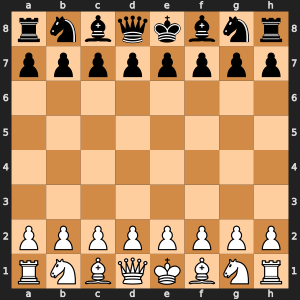

In [99]:
# inizializzazione gioco ed euristiche
chess_heuristic = ChessBoardEvaluationHeuristic()
chess_move_heuristic = ChessMoveEvaluation()
game = ChessGame()

# stato iniziale
initial_state = ChessState()
print("Stato iniziale")
print()
initial_state.print(mode="png")

- Data la lunghezza della partita (e quindi, della sequenza di stampe), è stato deciso di mantenere soltanto la stampa della mossa più recente

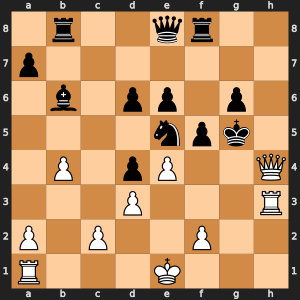


Ultima mossa: h7h4
Mossa dell'agente: agent 1 (White)


Risultato: Termination.CHECKMATE
Vincitore: White


In [51]:
# inizializzazione agenti
agent_1 = Agent(
    MinMaxAlphaBeta(
        heuristic=chess_heuristic,
        game=game,
        move_heuristic=chess_move_heuristic,
        max_depth=3,
    ),
    initial_state,
)
agent_2 = Agent(
    MinMaxAlphaBeta(
        heuristic=chess_heuristic,
        game=game,
        move_heuristic=chess_move_heuristic,
        max_depth=2,
    ),
    initial_state,
)
agents = [(agent_1, "agent 1 (White)"), (agent_2, "agent 2 (Black)")]

# inizio simulazione
main_two_agents(initial_state, agents, clear_prints=True, move_print=True, mode="png")

In [52]:
print(f"Stati valutati        (agente 1): {agent_1.search_algorithm.eval_count}")
print(f"Potature effettuate   (agente 1): {agent_1.search_algorithm.prune_count}")
print(f"Tempo di azione medio (agente 1): {agent_1.get_average_action_time()}")
print()
print(f"Stati valutati        (agente 2): {agent_2.search_algorithm.eval_count}")
print(f"Potature effettuate   (agente 2): {agent_2.search_algorithm.prune_count}")
print(f"Tempo di azione medio (agente 2): {agent_2.get_average_action_time()}")

Stati valutati        (agente 1): 92223
Potature effettuate   (agente 1): 4376
Tempo di azione medio (agente 1): 2.827041826248169

Stati valutati        (agente 2): 9809
Potature effettuate   (agente 2): 465
Tempo di azione medio (agente 2): 0.29342127839724225


# Statistiche

## Hardware utilizzato

- **Sistema**:
    - **Tipologia OS**: Linux
    - **Distro**: Artix Linux (derivata di Arch Linux)
    - **Bits**: 64 bit


- **Macchina**:
    - **Tipologia**: Laptop
    - **Anno uscita**: 01/25/2013


- **CPU**:
    - **Info**: Dual Core
    - **Modello**: Intel Core i7-3537U
    - **Bits**: 64 bit
    - **Velocità**: 1179 MHz
    - **Min / Max**: 800/3100 MHz


- **RAM**: 7.66 Gib

## Strumenti utilizzati

- Per quanto riguarda la creazione delle statistiche sui giochi implementati, si è deciso di utilizzare come supporto la libreria esterna [Pandas](https://pandas.pydata.org/). Essa fornisce funzioni ed oggetti molto utili alla rappresentazione e all'analisi dei dati estrapolati dai risultati dei test. L'installazione di essa avviene mediante il comando: `pip install pandas==1.2.5`

- Per quanto riguarda la visualizzazione delle statistiche nei grafici, si è deciso di utilizzare come supporto la libreria esterna [Matplotlib](https://matplotlib.org/). L'installazione di essa avviene mediante il comando: `pip install matplotlib==3.4.3`

## Infrastruttura semplificata per testare giochi a singolo agente

- Definizione dell'infrastruttura utilizzata per il test della simulazione di un singolo agente che agisce nel mondo

In [53]:
def main_single_agent(state: State, agent: Agent):
    while not state.is_endgame():
        state = agent.do_action(state)
        if state is None:
            return None

## Infrastruttura semplificata per testare giochi a 2 agenti (turn-based)

- Definizione dell'infrastruttura utilizzata per il test della simulazione di una coppia di agenti che agiscono nel mondo

In [54]:
def main_two_agents(state: TurnBasedState, agents: (Agent, str)):
    t = 0
    while not state.is_endgame():
        agent, agent_name = agents[t % 2]
        state = agent.do_action(state)
        t = t + 1
        if state is None:
            return None

## Definizioni utilizzate per eseguire i test

### Colonne dei DataFrames

In [55]:
df_single_agent_columns = [
    "dimensione orizzonte",
    "dimensione esplorati",
    "tempo azione medio (sec)",
    "tempo esecuzione totale (sec)",
]
df_multi_agent_columns = pd.MultiIndex.from_tuples(
    [
        ("Agente 1", "stati valutati"),
        ("Agente 1", "potature effettuate"),
        ("Agente 1", "tempo azione medio (sec)"),
        ("Agente 2", "stati valutati"),
        ("Agente 2", "potature effettuate"),
        ("Agente 2", "tempo azione medio (sec)"),
    ]
)
df_multi_agent_column_tot_time = "tempo esecuzione totale (sec)"

### Esecutore test per giochi a singolo agente

- Definizione della funzione che estrae dati dall'esecuzione del test sul gioco a singolo agente scelto

In [56]:
def execute_single_agent_test(
    game_test_function, HeuristicImpl, AlgorithmImpl, state, iterations
):
    df = pd.DataFrame(columns=df_single_agent_columns)
    for i in range(iterations):
        with contextlib.redirect_stdout(None):
            start_time = time.time()
            agent = game_test_function(HeuristicImpl, AlgorithmImpl, state)
            end_time = time.time()

            horizon_len = len(agent.search_algorithm.horizon)
            explored_len = len(agent.search_algorithm.explored)
            avg_action_time = agent.get_average_action_time()
            total_time = end_time - start_time

            df2 = pd.DataFrame(
                [[horizon_len, explored_len, avg_action_time, total_time]],
                columns=df_single_agent_columns,
            )
            df = df.append(df2, ignore_index=True)
    return df

### Esecutore test per giochi a 2 agenti

- Definizione della funzione che estrae dati dall'esecuzione del test sul gioco a 2 agenti scelto

In [57]:
def execute_multi_agent_test(
    game_test_function,
    AlgorithmImplAgent1,
    AlgorithmImplAgent2,
    agent_1_max_depth,
    agent_2_max_depth,
    state,
    iterations,
):
    df = pd.DataFrame(columns=df_multi_agent_columns)
    df[df_multi_agent_column_tot_time] = 0.0
    for i in range(iterations):
        with contextlib.redirect_stdout(None):
            start_time = time.time()
            agent_1, agent_2 = game_test_function(
                AlgorithmImplAgent1,
                AlgorithmImplAgent2,
                agent_1_max_depth,
                agent_2_max_depth,
                state,
            )
            end_time = time.time()

            agent_1_eval_count = agent_1.search_algorithm.eval_count
            agent_1_prune_count = agent_1.search_algorithm.prune_count
            agent_1_avg_action_time = agent_1.get_average_action_time()
            agent_2_eval_count = agent_2.search_algorithm.eval_count
            agent_2_prune_count = agent_2.search_algorithm.prune_count
            agent_2_avg_action_time = agent_2.get_average_action_time()
            total_time = end_time - start_time

            df2 = pd.DataFrame(
                [
                    [
                        agent_1_eval_count,
                        agent_1_prune_count,
                        agent_1_avg_action_time,
                        agent_2_eval_count,
                        agent_2_prune_count,
                        agent_2_avg_action_time,
                    ]
                ],
                columns=df_multi_agent_columns,
            )
            df2[df_multi_agent_column_tot_time] = total_time
            df = df.append(df2, ignore_index=True)
    return df

### Funzione di stampa delle istanze testate

In [58]:
def print_tested_instances(states):
    print("Applicazione dei test sulle seguenti istanze di gioco:", end="\n\n")
    for i, test in enumerate(states, start=1):
        print(f"Istanza {i}:")
        test.representation.print()
        print()

## Test su 8-puzzle

### Definizione funzione test per 8-puzzle

In [59]:
def run_8_puzzle_test(HeuristicImpl, AlgorithmImpl, state):
    heuristic = HeuristicImpl()
    game = EightPuzzleGame()

    initial_state = deepcopy(state)

    if AlgorithmImpl == A_star:
        search_algorithm = AlgorithmImpl(
            heuristic=heuristic,
            game=game,
            g_score_function=eight_puzzle_distance_from_root,
        )
    elif AlgorithmImpl == BestFirst:
        search_algorithm = AlgorithmImpl(heuristic=heuristic, game=game)
    else:
        raise RuntimeError("Algoritmo sconosciuto")

    agent = Agent(search_algorithm=search_algorithm, initial_state=initial_state)
    main_single_agent(initial_state, agent)

    return agent

### Creazione e stampa istanze testate

- Sebbene sia possibile generare istanze randomiche del gioco, è stato scelto di utilizzare istanze fissate (precedentemente generate in modo randomico) per la riproducibilità degli esperimenti.

In [60]:
state_1 = EightPuzzleState()
state_2 = EightPuzzleState()
state_2.representation.grid = eight_puzzle_grid_1
state_3 = EightPuzzleState()
state_3.representation.grid = eight_puzzle_grid_2
state_4 = EightPuzzleState()
state_4.representation.grid = eight_puzzle_grid_3
state_5 = EightPuzzleState()
state_5.representation.grid = eight_puzzle_grid_4
state_6 = EightPuzzleState()
state_6.representation.grid = eight_puzzle_grid_5

states = [state_1, state_2, state_3, state_4, state_5, state_6]

In [61]:
print_tested_instances(states)

Applicazione dei test sulle seguenti istanze di gioco:

Istanza 1:
 1  8  2 
 *  4  3 
 7  6  5 

Istanza 2:
 2  *  1 
 6  7  3 
 8  5  4 

Istanza 3:
 4  2  5 
 1  3  6 
 *  7  8 

Istanza 4:
 3  4  7 
 2  1  6 
 *  5  8 

Istanza 5:
 5  4  3 
 1  *  6 
 7  8  2 

Istanza 6:
 3  2  5 
 1  8  * 
 6  7  4 



### Test A* - Misplaces tiles

In [62]:
df_8p_as_mt = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_8_puzzle_test, EightPuzzleMisplacedTiles, A_star, state, 1
    )
    df_8p_as_mt = pd.concat([df_8p_as_mt, df], ignore_index=True)

df_8p_as_mt = df_8p_as_mt.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_8p_as_mt["algorithm"] = "A*"
df_8p_as_mt["heuristic"] = "Misplaced tiles"

In [63]:
df_8p_as_mt.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Misplaced tiles,A*,3276.666667,6564.166667,0.000821,13.862594


### Test A* - Manhattan distance

In [64]:
df_8p_as_md = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_8_puzzle_test, EightPuzzleManhattanDistance, A_star, state, 1
    )
    df_8p_as_md = pd.concat([df_8p_as_md, df], ignore_index=True)

df_8p_as_md = df_8p_as_md.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_8p_as_md["algorithm"] = "A*"
df_8p_as_md["heuristic"] = "Manhattan distance"

In [65]:
df_8p_as_md.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Manhattan distance,A*,399.166667,676.666667,0.00018,0.203388


### Test Best First - Misplaces tiles

In [66]:
df_8p_bf_mt = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_8_puzzle_test, EightPuzzleMisplacedTiles, BestFirst, state, 1
    )
    df_8p_bf_mt = pd.concat([df_8p_bf_mt, df], ignore_index=True)

df_8p_bf_mt = df_8p_bf_mt.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_8p_bf_mt["algorithm"] = "Best First"
df_8p_bf_mt["heuristic"] = "Misplaced tiles"

In [67]:
df_8p_bf_mt.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Misplaced tiles,Best First,253.5,391.166667,0.00018,0.087921


### Test Best First - Manhattan distance

In [68]:
df_8p_bf_md = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_8_puzzle_test, EightPuzzleManhattanDistance, BestFirst, state, 1
    )
    df_8p_bf_md = pd.concat([df_8p_bf_md, df], ignore_index=True)

df_8p_bf_md = df_8p_bf_md.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_8p_bf_md["algorithm"] = "Best First"
df_8p_bf_md["heuristic"] = "Manhattan distance"

In [69]:
df_8p_bf_md.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Manhattan distance,Best First,101.666667,144.666667,0.000121,0.0187


### Analisi e presentazione dei risultati

In [70]:
# rimuovere il commento per importare i dati dal dataset esistente
# df_res = pd.read_csv("datasets/8_puzzle_stats.csv")

In [71]:
df_res = pd.concat(
    [df_8p_as_mt, df_8p_as_md, df_8p_bf_mt, df_8p_bf_md], ignore_index=True
)

In [72]:
# salvataggio dataset
df_res.to_csv("datasets/8_puzzle_stats.csv", index=False)

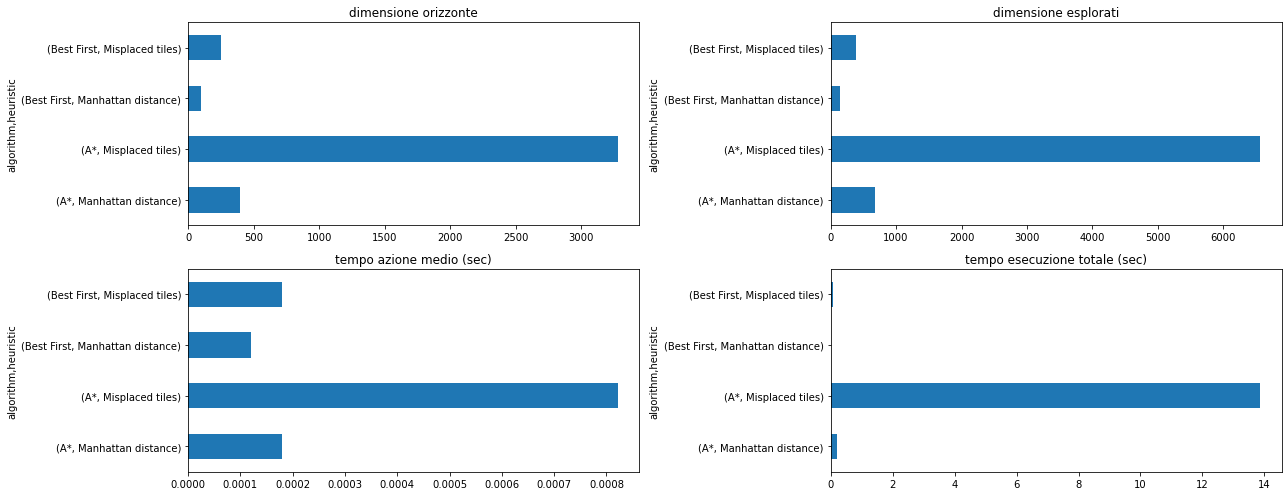

In [73]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 0].plot(
    kind="barh", ax=axes[0][0], figsize=(18, 7), title=df_res.columns[0]
)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 1].plot(
    kind="barh", ax=axes[0][1], figsize=(18, 7), title=df_res.columns[1]
)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 2].plot(
    kind="barh", ax=axes[1][0], figsize=(18, 7), title=df_res.columns[2]
)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 3].plot(
    kind="barh", ax=axes[1][1], figsize=(18, 7), title=df_res.columns[3]
)
fig.tight_layout()
plt.show()

Dai grafici estrapolati dai dati presi sulle istanze campione del gioco **8-Puzzle** possiamo effettuare diverse osservazioni:

- **Dimensione insieme stati orizzonte**: l'agente che esegue l'algoritmo A\* insieme all'euristica Misplaced tiles ha più stati nell'orizzonte rispetto agli altri agenti. Possiamo notare la differenza tra l'agente che esegue A\* insieme a Misplaced tiles e l'agente che esegue Best First insieme a Misplaced tiles.

- **Dimensione insieme stati esplorati**: si comporta in maniera del tutto simile alla **dimensione insieme stati orizzonte**.

- **Tempo azione medio**: l'agente che esegue l'algoritmo A\* insieme all'euristica Misplaced tiles impiega il tempo più alto per decidere l'azione da intraprendere. Questo fatto è probabilmente legato al numero maggiore di stati nell'orizzonte e negli esplorati rispetto agli altri agenti.

- **Tempo esecuzione totale**: l'esecuzione dell'agente che esegue l'algoritmo A\* insieme all'euristica Misplaced tiles impiega più tempo rispetto alle altre esecuzioni. L'incremento nel tempo di esecuzione totale dell'agente è probabilmente legato al numero maggiore di stati nell'orizzonte e negli esplorati rispetto agli altri agenti.

- Possiamo notare dai grafici che l'euristica Manhattan distance ha risultati migliori dell'euristica Misplaced tiles in tutti i risultati.

- Possiamo notare dai grafici **tempo azione medio** e **tempo esecuzione totale** che l'algoritmo Best First è generalmente più veloce dell'algoritmo A\*.

- Possiamo inoltre notare che il numero di stati esplorati è maggiore del numero di stati presenti nell'orizzonte.

## Test su Piano Mover

### Definizione funzione test per Piano Mover

In [74]:
def run_piano_mover_test(HeuristicImpl, AlgorithmImpl, state):
    heuristic = HeuristicImpl()
    game = PianoMoverGame()

    initial_state = deepcopy(state)

    if AlgorithmImpl == A_star:
        search_algorithm = AlgorithmImpl(
            heuristic=heuristic,
            game=game,
            g_score_function=piano_mover_distance_from_root,
        )
    elif AlgorithmImpl == BestFirst:
        search_algorithm = AlgorithmImpl(
            heuristic=heuristic,
            game=game,
        )
    else:
        raise RuntimeError("Algoritmo sconosciuto")

    search_algorithm.set_cutset_function(piano_mover_nearest_neighbors)

    agent = Agent(search_algorithm=search_algorithm, initial_state=initial_state)

    main_single_agent(initial_state, agent)

    return agent

### Creazione e stampa istanze testate

- Sebbene sia possibile generare istanze randomiche del gioco, è stato scelto di utilizzare istanze fissate (precedentemente generate in modo randomico) per la riproducibilità degli esperimenti.

In [75]:
state_1 = PianoMoverState()
state_1.representation.import_blocks_structure(piano_mover_grid_1)
state_2 = PianoMoverState()
state_2.representation.import_blocks_structure(piano_mover_grid_2)
state_3 = PianoMoverState()
state_3.representation.import_blocks_structure(piano_mover_grid_3)
state_4 = PianoMoverState()
state_4.representation.import_blocks_structure(piano_mover_grid_4)
state_5 = PianoMoverState()
state_5.representation.import_blocks_structure(piano_mover_grid_5)
state_6 = PianoMoverState()
state_6.representation.import_blocks_structure(piano_mover_grid_6)

states = [state_1, state_2, state_3, state_4, state_5, state_6]

In [76]:
print_tested_instances(states)

Applicazione dei test sulle seguenti istanze di gioco:

Istanza 1:
 0  0  0  0  0  1  0  0  3  0 
 0  0  0  0  0  0  0  0  3  0 
 0  0  3  3  3  0  0  0  3  3 
 0  0  0  0  0  0  0  0  3  3 
 0  0  0  0  0  0  0  0  0  0 
 0  2  0  3  0  0  3  3  0  0 
 0  2  2  3  0  0  3  0  0  0 
 0  0  2  3  0  0  0  0  0  0 
 0  0  0  0  0  0  3  3  4  4 
 0  0  0  0  0  0  3  0  4  4 

Istanza 2:
 0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0 
 3  3  0  0  3  0  0  0  0  0 
 3  0  0  3  3  0  0  0  0  0 
 0  0  0  0  0  3  3  0  3  0 
 0  0  3  0  0  0  3  0  3  0 
 4  4  3  3  0  0  0  0  3  0 
 4  4  0  0  1  3  0  0  0  0 
 0  0  0  0  3  3  0  2  2  0 
 0  0  0  0  2  2  0  0  0  0 

Istanza 3:
 0  0  0  0  0  0  3  3  0  0 
 1  0  0  0  3  0  3  0  0  0 
 0  0  0  0  3  3  0  0  0  0 
 4  4  0  0  0  0  0  0  0  0 
 4  4  0  0  0  0  0  0  0  2 
 0  3  0  0  0  0  0  0  0  2 
 0  3  3  3  3  0  0  0  0  0 
 0  3  3  0  2  2  0  0  0  0 
 0  3  3  3  0  0  0  0  0  0 
 0  3  3  

### Test A* - Manhattan distance

In [77]:
df_pm_as_md = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_piano_mover_test, PianoMoverManhattanDistance, A_star, state, 1
    )
    df_pm_as_md = pd.concat([df_pm_as_md, df], ignore_index=True)

df_pm_as_md = df_pm_as_md.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_pm_as_md["algorithm"] = "A*"
df_pm_as_md["heuristic"] = "Manhattan distance"

In [78]:
df_pm_as_md.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Manhattan distance,A*,3827.833333,845.666667,0.026732,23.842997


### Test A* - Manhattan distance obstacle density

In [79]:
df_pm_as_mdod = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_piano_mover_test,
        PianoMoverManhattanDistanceWithObstacleDensity,
        A_star,
        state,
        1,
    )
    df_pm_as_mdod = pd.concat([df_pm_as_mdod, df], ignore_index=True)

df_pm_as_mdod = df_pm_as_mdod.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_pm_as_mdod["algorithm"] = "A*"
df_pm_as_mdod["heuristic"] = "Manhattan distance obstacle density"

In [80]:
df_pm_as_mdod.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Manhattan distance obstacle density,A*,2163.5,475.833333,0.025867,13.11994


### Test Best First - Manhattan distance

In [81]:
df_pm_bf_md = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_piano_mover_test, PianoMoverManhattanDistance, BestFirst, state, 1
    )
    df_pm_bf_md = pd.concat([df_pm_bf_md, df], ignore_index=True)

df_pm_bf_md = df_pm_bf_md.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_pm_bf_md["algorithm"] = "Best First"
df_pm_bf_md["heuristic"] = "Manhattan distance"

In [82]:
df_pm_bf_md.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Manhattan distance,Best First,272.333333,36.166667,0.027697,1.015696


### Test Best First - Manhattan distance obstacle density

In [83]:
df_pm_bf_mdod = pd.DataFrame(columns=df_single_agent_columns)

for state in states:
    df = execute_single_agent_test(
        run_piano_mover_test,
        PianoMoverManhattanDistanceWithObstacleDensity,
        BestFirst,
        state,
        1,
    )
    df_pm_bf_mdod = pd.concat([df_pm_bf_mdod, df], ignore_index=True)

df_pm_bf_mdod = df_pm_bf_mdod.astype(
    {df_single_agent_columns[0]: "int64", df_single_agent_columns[1]: "int64"}
)

df_pm_bf_mdod["algorithm"] = "Best First"
df_pm_bf_mdod["heuristic"] = "Manhattan distance obstacle density"

In [84]:
df_pm_bf_mdod.groupby(["heuristic", "algorithm"]).mean()

,,dimensione orizzonte,dimensione esplorati,tempo azione medio (sec),tempo esecuzione totale (sec)
heuristic,algorithm,,,,
Manhattan distance obstacle density,Best First,215.166667,33.166667,0.025889,0.852863


### Analisi e presentazione dei risultati

In [85]:
# rimuovere il commento per importare i dati dal dataset esistente
# df_res = pd.read_csv("datasets/piano_mover_stats.csv")

In [86]:
df_res = pd.concat(
    [df_pm_as_md, df_pm_as_mdod, df_pm_bf_md, df_pm_bf_mdod],
    ignore_index=True,
)

In [87]:
# salvataggio dataset
df_res.to_csv("datasets/piano_mover_stats.csv", index=False)

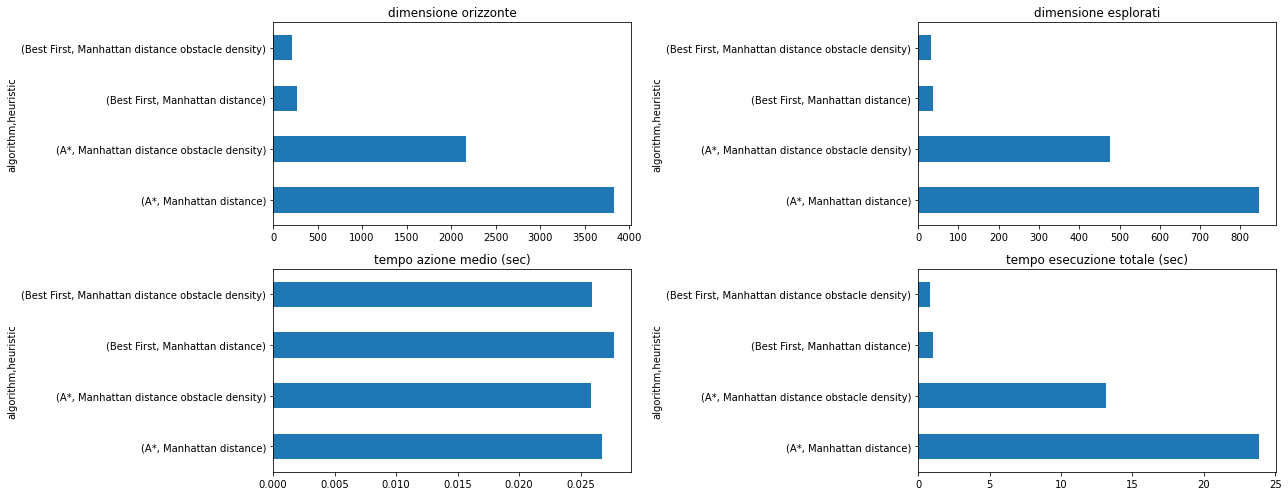

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 0].plot(
    kind="barh", ax=axes[0][0], figsize=(18, 7), title=df_res.columns[0]
)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 1].plot(
    kind="barh", ax=axes[0][1], figsize=(18, 7), title=df_res.columns[1]
)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 2].plot(
    kind="barh", ax=axes[1][0], figsize=(18, 7), title=df_res.columns[2]
)
df_res.groupby(["algorithm", "heuristic"]).mean().iloc[:, 3].plot(
    kind="barh", ax=axes[1][1], figsize=(18, 7), title=df_res.columns[3]
)
fig.tight_layout()
plt.show()

Dai grafici estrapolati dai dati presi sulle istanze campione del gioco **Piano Mover** possiamo effettuare diverse osservazioni:

- **Dimensione insieme stati orizzonte**: l'agente che esegue l'algoritmo A\* insieme all'euristica Manhattan distance ha più stati nell'orizzonte rispetto agli altri agenti. Inoltre possiamo notare la differenza marcata nel numero di stati dell'orizzonte tra l'agente che esegue Best First insieme ad Manhattan distance e l'agente che esegue A\* insieme ad Manhattan distance.

- **Dimensione insieme stati esplorati**: si comporta in maniera simile alla **dimensione insieme stati orizzonte**.

- **Tempo azione medio**: Possiamo notare che le differenze tra i tempi di azione non sono molto marcate tra i vari agenti.

- **Tempo esecuzione totale**: l'esecuzione dell'agente che esegue l'algoritmo A\* insieme all'euristica Manhattan distance impiega più tempo rispetto alle altre esecuzioni. L'incremento nel tempo di esecuzione è molto probabilmente legato al numero maggiore di stati presenti nell'orizzonte e negli esplorati.

- Possiamo notare che gli agenti che eseguono l'algoritmo A\* insieme all'euristica Manhattan Distance hanno risultati generalmente peggiori rispetto agli agenti che eseguono l'algoritmo Best First insieme all'euristica Manhattan Distance.

- Possiamo inoltre notare che il numero di stati presenti nell'orizzonte è maggiore del numero di stati esplorati.

- Per quanto riguarda l'euristica custom **Manhattan Distance obstacle density**, possiamo notare i seguenti risultati sui test eseguiti:
    - **dimensione orizzonte**: l'euristica presenta meno stati nell'orizzonte rispetto all'euristica Manhattan Distance standard con l'algoritmo A\*.
    - **dimensione esplorati**: l'euristica presenta meno stati esplorati rispetto all'euristica Manhattan Distance standard con l'algoritmo A\*.
    - **tempo esecuzione medio**: non c'è una differenza marcata nei risultati presentati.
    - **tempo esecuzione totale**: l'euristica porta ad un minor tempo di esecuzione totale dell'agente che la utilizza rispetto all'euristica Manhattan Distance standard con l'algoritmo A\*.

    In conclusione, sulle istanze testate, l'euristica custom **Manhattan Distance obstacle density** sembrerebbe portare un miglioramento rispetto all'euristica Manhattan Distance standard se utilizzata insieme all'algoritmo A\*.

## Test su Scacchi

### Definizione funzione test per Scacchi

In [89]:
def run_chess_test(
    AlgorithmImplAgent1,
    AlgorithmImplAgent2,
    agent_1_max_depth,
    agent_2_max_depth,
    state,
):
    chess_heuristic = ChessBoardEvaluationHeuristic()
    chess_move_heuristic = ChessMoveEvaluation()
    game = ChessGame()

    initial_state = deepcopy(state)

    if AlgorithmImplAgent1 == MinMax:
        algorithm_agent_1 = AlgorithmImplAgent1(
            heuristic=chess_heuristic,
            game=game,
            max_depth=agent_1_max_depth,
        )

    else:
        algorithm_agent_1 = AlgorithmImplAgent1(
            heuristic=chess_heuristic,
            game=game,
            move_heuristic=chess_move_heuristic,
            max_depth=agent_1_max_depth,
        )

    if AlgorithmImplAgent2 == MinMax:
        algorithm_agent_2 = AlgorithmImplAgent2(
            heuristic=chess_heuristic,
            game=game,
            max_depth=agent_2_max_depth,
        )
    else:
        algorithm_agent_2 = AlgorithmImplAgent2(
            heuristic=chess_heuristic,
            game=game,
            move_heuristic=chess_move_heuristic,
            max_depth=agent_2_max_depth,
        )

    agent_1 = Agent(
        algorithm_agent_1,
        initial_state,
    )
    agent_2 = Agent(
        algorithm_agent_2,
        initial_state,
    )
    agents = [(agent_1, "agent 1 (White)"), (agent_2, "agent 2 (Black)")]

    main_two_agents(initial_state, agents)

    return agent_1, agent_2

### Stampa scacchiera iniziale

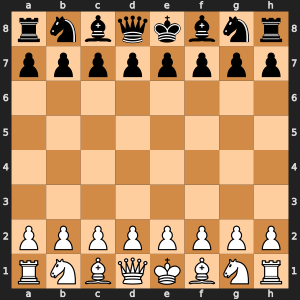

In [90]:
state = ChessState()
state.print("png")

### Test MinMax Alpha-Beta Pruning

In [91]:
df_chess_mnab = execute_multi_agent_test(
    run_chess_test, MinMaxAlphaBeta, MinMaxAlphaBeta, 3, 2, state, 1
)
df_chess_mnab = df_chess_mnab.astype(
    {
        df_multi_agent_columns[0]: "int64",
        df_multi_agent_columns[1]: "int64",
        df_multi_agent_columns[3]: "int64",
        df_multi_agent_columns[4]: "int64",
    }
)
df_chess_mnab["algorithm"] = "MinMax Alpha-Beta"

In [92]:
df_chess_mnab.groupby("algorithm").mean()

Agente 1                                               \
                  stati valutati potature effettuate tempo azione medio (sec)   
algorithm                                                                       
MinMax Alpha-Beta          92223                4376                 2.751096   

                        Agente 2                                               \
                  stati valutati potature effettuate tempo azione medio (sec)   
algorithm                                                                       
MinMax Alpha-Beta           9809                 465                 0.266705   

                  tempo esecuzione totale (sec)  
                                                 
algorithm                                        
MinMax Alpha-Beta                     75.180457

### Test MinMax

In [93]:
df_chess_mm = execute_multi_agent_test(run_chess_test, MinMax, MinMax, 3, 2, state, 1)
df_chess_mm = df_chess_mm.astype(
    {
        df_multi_agent_columns[0]: "int64",
        df_multi_agent_columns[1]: "int64",
        df_multi_agent_columns[3]: "int64",
        df_multi_agent_columns[4]: "int64",
    }
)
df_chess_mm["algorithm"] = "MinMax"

In [94]:
df_chess_mm.groupby("algorithm").mean()

Agente 1                                               \
          stati valutati potature effettuate tempo azione medio (sec)   
algorithm                                                               
MinMax           1062556                   0                21.118421   

                Agente 2                                               \
          stati valutati potature effettuate tempo azione medio (sec)   
algorithm                                                               
MinMax             18984                   0                 0.377706   

          tempo esecuzione totale (sec)  
                                         
algorithm                                
MinMax                       537.027758

### Analisi e presentazione dei risultati

In [95]:
# rimuovere il commento per importare i dati dal dataset esistente
# df_res = pd.read_csv("datasets/chess_stats.csv")

In [96]:
df_res = pd.concat(
    [df_chess_mnab, df_chess_mm],
    ignore_index=True,
)

In [97]:
# salvataggio dataset
df_res.to_csv("datasets/chess_stats.csv", index=False)

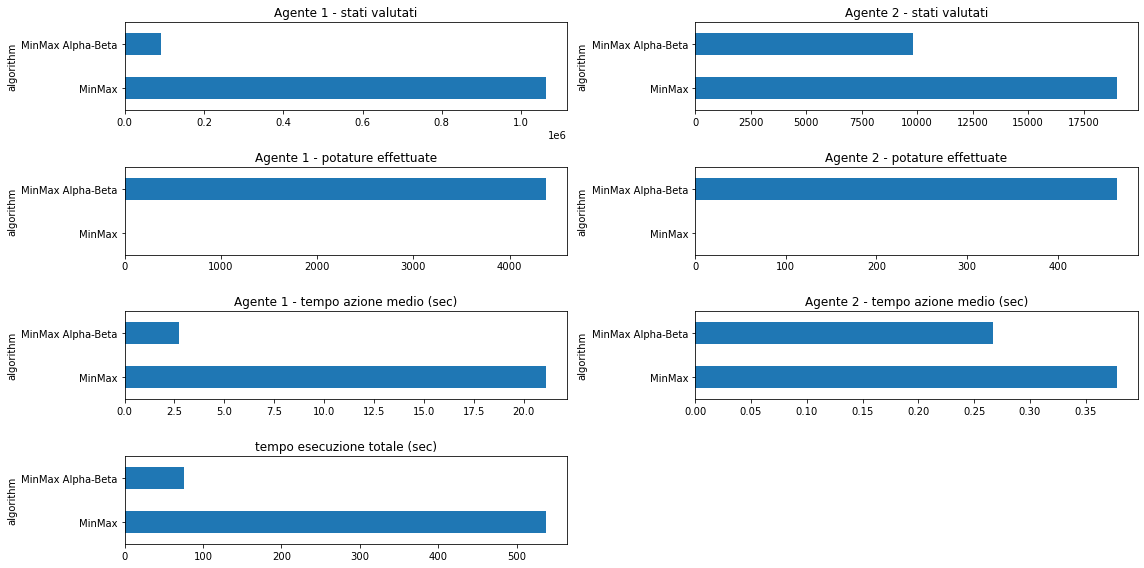

In [98]:
fig, axes = plt.subplots(nrows=4, ncols=2)
df_res.groupby("algorithm").mean().iloc[:, 0].plot(
    kind="barh", ax=axes[0][0], figsize=(16, 8), title=" - ".join(df_res.columns[0])
)
df_res.groupby("algorithm").mean().iloc[:, 3].plot(
    kind="barh", ax=axes[0][1], figsize=(16, 8), title=" - ".join(df_res.columns[3])
)
df_res.groupby("algorithm").mean().iloc[:, 1].plot(
    kind="barh", ax=axes[1][0], figsize=(16, 8), title=" - ".join(df_res.columns[1])
)
df_res.groupby("algorithm").mean().iloc[:, 4].plot(
    kind="barh", ax=axes[1][1], figsize=(16, 8), title=" - ".join(df_res.columns[4])
)
df_res.groupby("algorithm").mean().iloc[:, 2].plot(
    kind="barh", ax=axes[2][0], figsize=(16, 8), title=" - ".join(df_res.columns[2])
)
df_res.groupby("algorithm").mean().iloc[:, 5].plot(
    kind="barh", ax=axes[2][1], figsize=(16, 8), title=" - ".join(df_res.columns[5])
)
df_res.groupby("algorithm").mean().iloc[:, 6].plot(
    kind="barh", ax=axes[3][0], figsize=(16, 8), title=df_res.columns[6][0]
)
fig.delaxes(axes[3][1])
fig.tight_layout()
plt.show()

Sono stati eseguiti 2 agenti sull'istanza iniziale del gioco degli **Scacchi**.

L'agente 1 ha giocato il turno del giocatore Bianco mentre l'agente 2 ha giocato il turno del giocatore Nero.

Per mostrare quanto la profondità massima degli algoritmi possa influire sui risultati, è stata settata a 3 la profondità massima dell'agente 1, ed è stata settata a 2 la profondità massima dell'agente 2.

Dai grafici estrapolati dai dati presi possiamo effettuare diverse osservazioni:

- **Grafici su agente 1** (profondità max: 3):
    - **Numero stati valutati**: è molto evidente il fatto che l'agente che esegue l'algoritmo MinMax valuti molti più stati rispetto all'agente che esegue MinMax Alpha-Beta. Questo deriva dal fatto che l'algoritmo MinMax non utilizza alcuna logica di potatura dell'albero degli stati.

    - **Potature effettuate**: l'agente che esegue MinMax Alpha-Beta è l'unico agente che effettua potature (l'algoritmo MinMax non utilizza alcuna logica di potatura).

    - **Tempo azione medio**: è molto evidente il fatto che l'agente che esegue l'algoritmo MinMax impieghi molto più tempo per decidere l'azione da intraprendere rispetto all'altro agente. Sicuramente la mancanza della potatura e di conseguenza il maggiore numero di stati valutati influiscono drasticamente su questo aspetto.


- **Grafici su agente 2** (profondità max: 2):
    - **Numero stati valutati**: l'agente che esegue l'algoritmo MinMax valuta più stati rispetto all'altro agente. Il gap tra l'agente che esegue MinMax e l' agente che esegue MinMax Alpha-Beta risulta ridotto rispetto al grafico **numero stati valutati** dell'agente 1 a causa, probabilmente, della minore profondità massima settata (profondità settata a 2 invece di 3).

    - **Potature effettuate**: l'agente che esegue MinMax Alpha-Beta è l'unico agente che effettua potature (l'algoritmo MinMax non utilizza alcuna logica di potatura). Possiamo notare che, a causa della minore profondità massima settata, le potature di MinMax Alpha-Beta sono drasticamente minori rispetto al grafico **potature effettuate** dell'agente 1.

    - **Tempo azione medio**: l'agente che esegue l'algoritmo MinMax impiega più tempo per decidere l'azione da intraprendere rispetto all'altro agente. Il gap tra l'agente che esegue MinMax e l'altro agente risulta ridotto rispetto al grafico **tempo azione medio** dell'agente 1 a causa, probabilmente, della minore profondità massima settata (profondità settata a 2 invece di 3).


- **Tempo esecuzione totale**: è molto evidente il fatto che l'esecuzione dell'agente che esegue l'algoritmo MinMax impieghi molto più tempo rispetto all'esecuzione dell'agente che esegue l'algoritmo MinMax Alpha-Beta. Sicuramente la mancanza della potatura e di conseguenza il numero maggiore di stati valutati influiscono drasticamente su questo aspetto.


- Possiamo inoltre notare come il numero di potature di MinMax Alpha-Beta salga drasticamente al salire della profondità massima dell'algoritmo. (come è possibile notare confrontando i grafici **potature effettuate** dell'agente 1 e dell'agente 2).

- Possiamo inoltre notare come MinMax Alpha-Beta funzioni meglio al salire della profondità massima (il gap tra MinMax e MinMax Alpha-Beta diventa sempre più grande al salire della profondità massima). Probabilmente questo accade poichè, con l'incremento della profondità massima, MinMax Alpha-Beta effettua un numero maggiore di potature (come è possibile notare confrontando i grafici **stati valutati** dell'agente 1 e dell'agente 2 e confrontando i grafici **potature effettuate** dell'agente 1 e dell'agente 2).